# Хакатон Яндекс Музыки. Обнаружение каверов музыкальных треков

## Что необходимо сделать?

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

В этом хакатоне вам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Совсем не обязательно, чтобы ваше решение умело делать все три функции. Будет уже здорово, если вы сможете придумать решение хотя бы для одной задачи.

Для решения этой задачи вы можете использовать любые открытые источники данных и собирать необходимую вам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

## Описание данных

### Разметка каверов covers.json

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

Не для всех каверов известны идентификаторы исходных треков!!!

### Метаинформация meta.json

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен lyrics.json

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## План работы:

1. Загрузка и первичный анализ датасетов
2. Исследовательский анализ данных
3. Подготовка данных к машинному обучению
4. Обучение моделей
7. Финальный вывод

### Техническая часть с загрузкой библиотек и функций

In [1]:
# !pip install ydata-profiling
# !pip install langid
# !pip install nltk
# !pip install --upgrade typing_extensions
# !pip install --upgrade pandas_profiling

# !pip install transformers
# # убирал ошибки версии
# !pip install accelerate -U
# !pip install transformers[torch]

In [133]:
# Основные библиотеки
import json
import math
import re
import warnings
from collections import defaultdict
from textwrap import wrap

# Для анализа данных
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

# Машинное обучение и обработка данных
import langid
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.stem import SnowballStemmer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (auc, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score, roc_curve,ConfusionMatrixDisplay)
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,LabelEncoder
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import cosine_similarity



# Настройки
RANDOM_SEED = 42
warnings.filterwarnings('ignore')

# Deep Learning и NLP
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import (AdamW, AutoModel, AutoModelForMaskedLM,
                          AutoModelForSequenceClassification, BertConfig,
                          BertForSequenceClassification, BertModel,
                          BertTokenizer, get_linear_schedule_with_warmup,
                          Trainer, TrainingArguments)
from torchsummary import summary

# Вспомогательные библиотеки
from tqdm.notebook import tqdm
tqdm.pandas()

import transformers
from transformers import BertModel, BertTokenizer, BertConfig

# Загрузите модель и т


# Настройка визуализации
%matplotlib inline
plt.rcdefaults()

# Проверка успешности импорта
try:
    print('Библиотеки ок')
except ImportError as e:
    print(f'Ошибка при импорте: {e}')



Библиотеки ок


In [134]:
import pkg_resources
import re

# Список используемых библиотек
libraries = [
    'numpy', 'pandas', 'ydata-profiling',
    'matplotlib', 'seaborn', 'langid', 'catboost', 'lightgbm', 'nltk', 'sklearn',
    'xgboost', 'torch', 'transformers', 'tqdm', 'torchsummary'
]

# Получаем список установленных пакетов и их версий
installed_packages = {pkg.key for pkg in pkg_resources.working_set}

# Создаем список зависимостей с версиями
dependencies = []
for library in libraries:
    # Некоторые библиотеки могут быть встроенными или не иметь версии, проверяем это
    if library in installed_packages:
        version = pkg_resources.get_distribution(library).version
        dependencies.append(f"{library}=={version}")
    else:
        print(f"{library} не установлен или не имеет версии.")

# Записываем зависимости в файл
with open('requirements.txt', 'w') as f:
    f.write('\n'.join(dependencies))
!type requirements.txt

numpy==1.23.5
pandas==1.5.2
ydata-profiling==4.6.1
matplotlib==3.6.2
seaborn==0.12.1
langid==1.1.6
catboost==1.2
lightgbm==3.3.5
nltk==3.8.1
sklearn==0.0.post1
xgboost==1.7.5
torch==2.0.1+cu117
transformers==4.25.1
tqdm==4.64.1
torchsummary==1.5.1


## Функции

In [3]:
# Функция для чтения содержимого JSON файла
def read_multiple_json_objects(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read().strip()
        objs = [json.loads(line) for line in content.splitlines()]
    return objs

# Функция для чтения содержимого JSON файла и преобразования его в DataFrame
def read_multiple_json_objects_to_df(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read().strip().split("\n")  # Разбиваем содержимое файла по строкам
    data_list = [json.loads(line) for line in content if line]
    return pd.DataFrame(data_list)

In [4]:
def data_info(dataframe):
    """
    Функция принимает на вход датафрейм,
    а на выходе выводит все необходимые характеристики поочередно применяя методы:
    """
    # выводим первые и последние 5 строк датафрейма
    print('Выведем первые и последние 5 строк:')
    display(pd.concat([dataframe.head(), dataframe.tail()]))

    # выводим общую информацию о датафрейме
    print('\nВыведем общую информацию по датафрейму:')
    display(dataframe.info())

    #
    print('\nВыведем статистическую информацию по датафрейму:')
    display(dataframe.describe(include='all').T)

    # выводим информацию о типах данных признаков
    print('\nПосмотрим на признаки:')
    for num, col in enumerate(dataframe.columns):
        num += 1
        unique_values = len(dataframe[col].unique())
        missing_values = dataframe[col].isnull().sum()
        total_values = dataframe[col].count()
        print(f'{num}. {col} - тип данных {dataframe[col].dtype}, уникальных значений: {unique_values}, '
            f'пропущенных значений: {missing_values}, всего значений: {total_values}')
        # print(f'Список уникальных значений:\n{dataframe[i].sort_values().unique()}\n')

    # выводим информацию о пропущенных значениях
    print('\nПосмотрим пропуски:')
    display(dataframe.isnull().sum())

    # выводим количество дубликатов
    dup_count = dataframe.duplicated().sum()
    print(f'\nКоличество дубликатов: {dup_count}')

In [5]:
def detect_language(text):
    """
    Функция для определения языка текста с помощью библиотеки langid.

    Аргументы:
    text -- текст, язык которого нужно определить

    Возвращает:
    строку с двухбуквенным кодом языка, если язык удалось определить, или строку 'no_language', если текст не содержит достаточно информации для определения языка, или произошла ошибка при определении языка.
    """
    if text == 'no_text':
        return 'no_language'
    else:
        try:
            return langid.classify(text)[0]
        except:
            return 'no_language'

In [6]:
def numeric_hist_boxplot(dataframe, features_list):
    '''
    Функция принимает на вход датафрейм, список с числовыми признаками
    и строит по ним гистограммы распределения и ящики с усами
    '''
    # Проходим по каждому признаку в списке
    for feature in features_list:
        # Создаем графическую область с двумя подграфиками
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        # Строим гистограмму
        sns.histplot(dataframe[feature], bins=30, ax=ax[0], kde=True)
        fig.suptitle(f'Распределение признака {feature}', size=12)

        # Строим боксплот
        sns.boxplot(dataframe[feature], ax=ax[1], orient='v', width=0.3, color='skyblue')

        # Настройки подграфика гистограммы
        ax[0].set_xlabel(f'{feature}')
        ax[0].set_ylabel('Частота')
        ax[0].set_title('Гистограмма распределения')

        # Настройки подграфика боксплота
        ax[1].set_xlabel('Признак')
        ax[1].set_ylabel(f'{feature}')
        ax[1].set_title('Ящик с усами')

        # Выводим графики для текущего признака
        plt.show()

In [7]:
def plot_pie_chart(df, target_col, figsize=(6, 6), labeldistance=1.1, pctdistance=0.85, fontsize=12, title=''):
    """
    Функция для создания диаграммы pie на основе целевого признака в датафрейме.

    Параметры:
    - df: Pandas DataFrame с данными.
    - target_col: Строка, представляющая название целевого признака в датафрейме.
    - figsize: Кортеж, определяющий размеры диаграммы (по умолчанию: (6, 6)).
    - labeldistance: Расстояние между центром диаграммы и подписями (по умолчанию: 1.1).
    - pctdistance: Расстояние между центром диаграммы и процентными значениями (по умолчанию: 0.85).
    - fontsize: Размер шрифта для подписей (по умолчанию: 12).
    - title: Заголовок диаграммы (по умолчанию: '').

    """
    churn_counts = df[target_col].value_counts()
    labels = churn_counts.index.tolist()

    fig, ax = plt.subplots(figsize=figsize)

    pie = ax.pie(churn_counts, labels=labels, autopct='%1.1f%%', labeldistance=labeldistance, pctdistance=pctdistance)

    # Регулировка размера подписей
    for label in pie[1]:
        label.set_fontsize(fontsize)

    my_circle = plt.Circle((0, 0), 0.7, color='white')
    ax.add_artist(my_circle)

    plt.title(title)
    plt.show()

In [8]:
def preprocess_and_tokenize(text, cache=None):
    """
    Функция принимает на вход текст и выполняет предварительную обработку и токенизацию.
    Возвращает предобработанный текст.

    Аргументы:
    - text (str): Входной текст, который требуется обработать.
    - cache (dict): (optional) Кэш для хранения результатов стемминга.

    Возвращает:
    - str: Предобработанный текст.
    """
    # Удаление символов новой строки
    text = text.replace('\n', ' ')

    # Удаление двойных пробелов
    text = re.sub(' +', ' ', text)

    if not isinstance(text, str) or len(text) == 0:
        return ""

    # Проверка, содержит ли текст только символы новой строки
    if text.strip() == "":
        return ""  # или возврат значения по умолчанию

    # Определение языка текста
    language, _ = langid.classify(text)

    # Инициализация стеммера для соответствующего языка
    try:
        stemmer = SnowballStemmer(language)
    except ValueError:
        stemmer = SnowballStemmer("english")

    # Токенизация текста
    tokens = re.findall(r'\b\w+\b', text)

    words_lem = []  # Список для хранения предобработанных и лемматизированных слов
    added_words = set()  # Множество для отслеживания добавленных слов

    for token in tokens:
        if len(token) > 1:
            # Проверка кэша для повторного использования результатов стемминга
            if cache is None or token not in cache:
                lem_token = stemmer.stem(token)  # Лемматизация для всех языков

                # Кэширование результата стемминга
                if cache is not None:
                    cache[token] = lem_token

            else:
                lem_token = cache[token]

            if lem_token not in added_words:
                words_lem.append(lem_token)
                added_words.add(lem_token)

    # Объединение предобработанных слов в строку
    preprocessed_text = " ".join(words_lem)
    return preprocessed_text

In [9]:
def get_scatter(X, y, title, svd=True):
    """
    Функция для визуализации данных на плоскости с использованием метода SVD.
    Аргументы:
    X - матрица признаков размерности (n_samples, n_features), где n_samples - количество объектов, а n_features - количество признаков.
    y - вектор меток классов размерности (n_samples).
    title - заголовок графика.
    svd - флаг, указывающий, нужно ли использовать метод SVD для снижения размерности данных (по умолчанию True).
    Возвращаемое значение:
    График с точками на плоскости, где каждая точка представляет объект из набора данных,
    цвет точки соответствует метке класса, а размер точки зависит от значения вектора y
    (если значение метки класса равно 1, то размер точки равен 2, в противном случае равен 1).
    """
    if svd:
        # Снижение размерности данных до 2 компонент с помощью метода SVD
        svd = TruncatedSVD(n_components=2)
        X = svd.fit_transform(X)

    # Задание размеров точек на графике в зависимости от метки класса
    sizes = [2 if label == 1 else 1 for label in y]

    # Создание объектов фигуры и осей графика с заданным размером
    fig, ax = plt.subplots(figsize=(15, 5))
    # Рисование точек на графике
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap('RdYlBu_r'), s=sizes)
    # Задание заголовка графика, а также скрытие делений на осях
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    # Создание списка объектов типа Line2D, представляющих элементы легенды на графике
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=8,
                   markerfacecolor=scatter.get_cmap()(1.0), label='Кавера'),
        plt.Line2D([0], [0], marker='o', color='w', markersize=8,
                   markerfacecolor=scatter.get_cmap()(0.0), label='Оригиналы')
    ]
    # Добавление легенды на график
    ax.legend(handles=legend_elements)
    # Отображение графика
    plt.show()

In [12]:
def test_model(X_train, y_train, pipeline, param_grid, cv_params={'n_splits': 5, 'shuffle': True, 'random_state': 42},
               scoring='roc_auc', verbose=10):
    """
    Функция test_model выполняет оценку и тестирование модели машинного обучения с использованием метода
    кросс-валидации и поиска оптимальных гиперпараметров.
    Аргументы:
    X_train: обучающая выборка, содержащая признаки
    y_train: обучающая выборка, содержащая целевую переменную
    pipeline: Pipeline, содержащий шаги предобработки и модель
    param_grid: словарь с сеткой гиперпараметров для перебора
    cv_params: параметры для объекта StratifiedKFold
    scoring: метрика для оценки
    verbose: уровень логирования
    """

    # Создаем объект KFold для кроссвалидации
    skf = StratifiedKFold(**cv_params)

    # Создаем объект GridSearchCV для подбора гиперпараметров
    search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                          scoring=scoring, n_jobs=-1, cv=skf,
                          verbose=verbose, refit=True)
    try:
        # Обучаем объект GridSearchCV на обучающей выборке
        search.fit(X_train, y_train)

        # Извлекаем лучшую модель и ее гиперпараметры
        best_model = search.best_estimator_
        best_params = search.best_params_
        model_name = best_model.named_steps['model'].__class__.__name__

        # Вычисляем метрики на кросс-валидации
        best_score = search.best_score_

        # Выводим название модели, лучшие гиперпараметры и метрики
        result = {
            'Модель': model_name,
            'Гиперпараметры': best_params,
            'Лучшая метрика (AUC)': best_score
        }

        # Возвращаем результаты и лучшую модель
        return result, best_model
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None



In [11]:
def evaluate_model(model, features_test, target_test):
    """
    Функция для оценки модели на тестовой выборке.

    Аргументы:
    - model: обученная модель, которую необходимо оценить
    - features_test: матрица признаков тестовой выборки

    Вывод:
    - Имя модели
    - ROC-AUC на тестовой выборке
    - Точность (Accuracy) на тестовой выборке
    - Матрица ошибок
    - ROC-кривая
    """

    # Получение имени модели
    model_name = model.named_steps['model'].__class__.__name__

    # Предсказание на тестовой выборке
    predictions = model.predict(features_test)
    probabilities = model.predict_proba(features_test)[:, 1]


    # Вычисление метрик
    roc_auc = roc_auc_score(target_test, probabilities)
    f1 = f1_score(target_test, predictions)  # Добавляем вычисление F1-скора

    # Вывод результатов
    print("Модель:", model_name)
    print("ROC-AUC на тестовой выборке:", round(roc_auc, 4))
    print("F1-скор на тестовой выборке:", round(f1, 4))  # Добавляем вывод F1-скора
    print('Резмер тестовой выборки:', target_test.shape)



    # # Вычисление метрик
    # roc_auc = roc_auc_score(target_test, probabilities)
    # # accuracy = accuracy_score(target_test, predictions)
    #
    # # Построение матрицы ошибок
    cm = confusion_matrix(target_test, predictions)
    #
    # # Вывод результатов
    # print("Модель:", model_name)
    # print("ROC-AUC на тестовой выборке:", round(roc_auc, 4))
    # # print("Точность (Accuracy) на тестовой выборке:", round(accuracy, 4))
    # print('Резмер тестовой выборки:', target_test.shape)
    # #print("Матрица ошибок:")
    # #print(cm)

    # Создание графиков на одной строке
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Построение матрицы ошибок с использованием Seaborn
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[0])
    axes[0].set_title(f'Матрица ошибок\n[TN, FP]\n[FN, TP]')
    axes[0].set_xlabel('Предсказанные классы')
    axes[0].set_ylabel('Реальные классы')

    # Построение ROC-кривой с использованием Seaborn
    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    sns.lineplot(data=roc_data, x='FPR', y='TPR', label=f'ROC-кривая (AUC = {roc_auc:.2f})', ax=axes[1])
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', ax=axes[1])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC-Кривая')
    axes[1].legend(loc='lower right')


    # Отображение графиков
    plt.tight_layout()
    plt.show()

## 1. Загрузка и первичный анализ датасетов

In [10]:
# Чтение файлов
covers_df = read_multiple_json_objects_to_df('data/covers.json')
lyrics_df = read_multiple_json_objects_to_df('data/lyrics.json')
meta_df = read_multiple_json_objects_to_df('data/meta.json')

## Общая информация:
- Размер датафрейма, типы данных, наличие пропущенных значений.
- Распределение треков по типам: Сколько оригинальных треков и кавер-версий.
- Анализ оригинальных треков: Сколько из них имеют кавер-версии и сколько не имеют.
- Анализ кавер-версий: Сколько уникальных оригинальных треков имеют каверы и какое максимальное и минимальное количество кавер-версий на один оригинальный трек.
- Пропущенные значения: Анализ пропущенных значений и их возможное значение.

In [11]:
# Размер датафрейма, типы данных, наличие пропущенных значений.
general_info = covers_df.info()

# 2. Сколько оригинальных треков и кавер-версий.
track_distribution = covers_df['track_remake_type'].value_counts()

# 3. Сколько из них имеют кавер-версии и сколько не имеют.
original_tracks = covers_df[covers_df['track_remake_type'] == 'ORIGINAL']['track_id'].unique()
originals_with_identified_covers = covers_df[covers_df['original_track_id'].isin(original_tracks)]
unique_originals_with_covers = originals_with_identified_covers['original_track_id'].nunique()
originals_without_covers = len(original_tracks) - unique_originals_with_covers

# 4. Сколько уникальных оригинальных треков имеют каверы и какое максимальное и минимальное количество кавер-версий на один оригинальный трек.

covers_only = covers_df[covers_df['track_remake_type'] == 'COVER']
covers_grouped_by_original = covers_only.groupby('original_track_id').size()
max_covers_for_single_original = covers_grouped_by_original.max()
min_covers_for_single_original = covers_grouped_by_original.min()


# 5. Анализ пропущенных значений и их возможное значение.
missing_values = covers_df.isnull().sum()

display(general_info)
display('Сколько оригинальных треков и кавер-версий.','*'*50)
display(track_distribution)
display(' Сколько из них имеют кавер-версии и сколько не имеют.','*'*50)
display(originals_without_covers, unique_originals_with_covers)
display('*'*50)
display(max_covers_for_single_original, min_covers_for_single_original)
display('*'*50)
display(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


None

'Сколько оригинальных треков и кавер-версий.'

'**************************************************'

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

' Сколько из них имеют кавер-версии и сколько не имеют.'

'**************************************************'

0

4293

'**************************************************'

37

1

'**************************************************'

original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64

## lyrics_df
(дубли, уникальные)

In [12]:
lyrics_df.head()
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [13]:
lyric_id_counts = lyrics_df['lyricId'].value_counts()
lyric_id_counts.head()

28fbafaf626c497d0d4d933b4f0d3f5b    9
6fe05ce48761f833737487cd7a499cd3    9
8a6cbc757ea47cc19dd9d7a086940dab    8
ab6de5670780dc1f57dc67812aae0638    8
e2463f89474976a107df828106a43fc1    8
Name: lyricId, dtype: int64

In [14]:
s=lyrics_df.nunique()
s

lyricId     10915
text        10644
track_id    10277
dtype: int64

## meta_df

In [15]:

meta_df.head()

track_id          dttm                 title  \
0  c3b9d6a354ca008aa4518329aaa21380  1.639688e+12        Happy New Year   
1  c57e3d13bbbf5322584a7e92e6f1f7ff  1.637762e+12            Bad Habits   
2  955f2aafe8717908c140bf122ba4172d  1.637768e+12  Por Esa Loca Vanidad   
3  fae5a077c9956045955dde02143bd8ff  1.637768e+12          Mil Lagrimas   
4  6bede082154d34fc18d9a6744bc95bf5  1.637768e+12   Sexo Humo y Alcohol   

  language          isrc             genres  duration  
0       EN  RUB422103970            [DANCE]  161120.0  
1       EN  QZN882178276      [ELECTRONICS]  362260.0  
2     None  QZNJZ2122549  [FOLK, LATINFOLK]  260000.0  
3     None  QZNJZ2166033  [FOLK, LATINFOLK]  190000.0  
4     None  QZNJZ2122551  [FOLK, LATINFOLK]  203000.0

In [16]:
meta_df.columns

Index(['track_id', 'dttm', 'title', 'language', 'isrc', 'genres', 'duration'], dtype='object')

In [17]:
meta_df_counts = meta_df['language'].value_counts()
meta_df_counts.head(15)

EN    15322
ES     1747
RU     1558
IT      907
HI      285
DE      238
ZH      212
FR      210
JA      174
VI      162
TH      162
PT      114
ID      111
PA       50
SI       49
Name: language, dtype: int64

In [18]:
meta_df_counts = meta_df['genres'].value_counts()
meta_df_counts.head(15)

[FOLK, LATINFOLK]              18391
[POP]                          13157
[ROCK, ALLROCK]                 5898
[ALTERNATIVE]                   3570
[FOLK]                          2645
[]                              2352
[ELECTRONICS]                   2231
[SOUNDTRACK]                    2181
[DANCE]                         2166
[SPIRITUAL]                     1552
[RAP]                           1531
[POP, RUSPOP]                   1436
[CLASSICAL, CLASSICALMUSIC]      980
[JAZZ]                           818
[CLASSICMETAL, METAL]            666
Name: genres, dtype: int64

In [19]:
lyric_id_counts = meta_df['isrc'].value_counts()
lyric_id_counts

USTCF1018560    3
USTCF1017794    3
FR33T0819525    3
FR59R2297788    2
QZNC62100408    2
               ..
QZHZ52133544    1
QZHN92184835    1
QZHZ52129987    1
QZMHN2006080    1
FR59R1921791    1
Name: isrc, Length: 71283, dtype: int64

In [20]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


### сведение covers_df meta_df по track_id
**(merged1_df)**

надо определить каких данных нам не хватает для построение модели

In [21]:
merged1_df = covers_df.merge(meta_df, on='track_id')


merged1_df.head()

original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                              None  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type          dttm            title language          isrc  \
0          ORIGINAL  1.257973e+12       Proud Mary       EN  USFI86900049   
1          ORIGINAL  1.257973e+12    Fortunate Son       EN  USFI86900065   
2          ORIGINAL  1.253563e+12  La Camisa Negra       ES  USUL10400965   
3          ORIGINAL  1.258405e+12    The Way I Are       EN  USUM70722806   
4             COVER  1.253218e+12        Extraball       EN  FR8Q10900116   

                   genres  duration  
0         [ROCK, ALLROCK]  187220.0  
1         [ROCK, ALLROCK]  137780.0  
2  [POP, FOLK, LATINFOLK]  216840.0  
3       [FOREIGNRAP, RAP]  179660.0  
4           [ELECTRONICS]  212620.0

In [22]:
merged1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71597 entries, 0 to 71596
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71597 non-null  object 
 2   track_remake_type  71597 non-null  object 
 3   dttm               71597 non-null  float64
 4   title              71597 non-null  object 
 5   language           21826 non-null  object 
 6   isrc               71287 non-null  object 
 7   genres             71597 non-null  object 
 8   duration           71597 non-null  float64
dtypes: float64(2), object(7)
memory usage: 5.5+ MB


In [23]:
# Преобразуем столбец с датами из формата timestamp в нормальный формат даты
merged1_df['dttm'] = pd.to_datetime(merged1_df['dttm'], unit='ms')

In [24]:
merged1_df.head()

original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                              None  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type                dttm            title language  \
0          ORIGINAL 2009-11-11 21:00:00       Proud Mary       EN   
1          ORIGINAL 2009-11-11 21:00:00    Fortunate Son       EN   
2          ORIGINAL 2009-09-21 20:00:00  La Camisa Negra       ES   
3          ORIGINAL 2009-11-16 21:00:00    The Way I Are       EN   
4             COVER 2009-09-17 20:00:00        Extraball       EN   

           isrc                  genres  duration  
0  USFI86900049         [ROCK, ALLROCK]  187220.0  
1  USFI86900065         [ROCK, ALLROCK]  137780.0  
2  USUL10400965  [POP, FOLK, LATINFOLK]  216840.0  
3  USUM70722806       [FOREIGNRAP, RAP]  179660.0  
4  FR8Q10900116           [ELECTRONICS]  212620.0

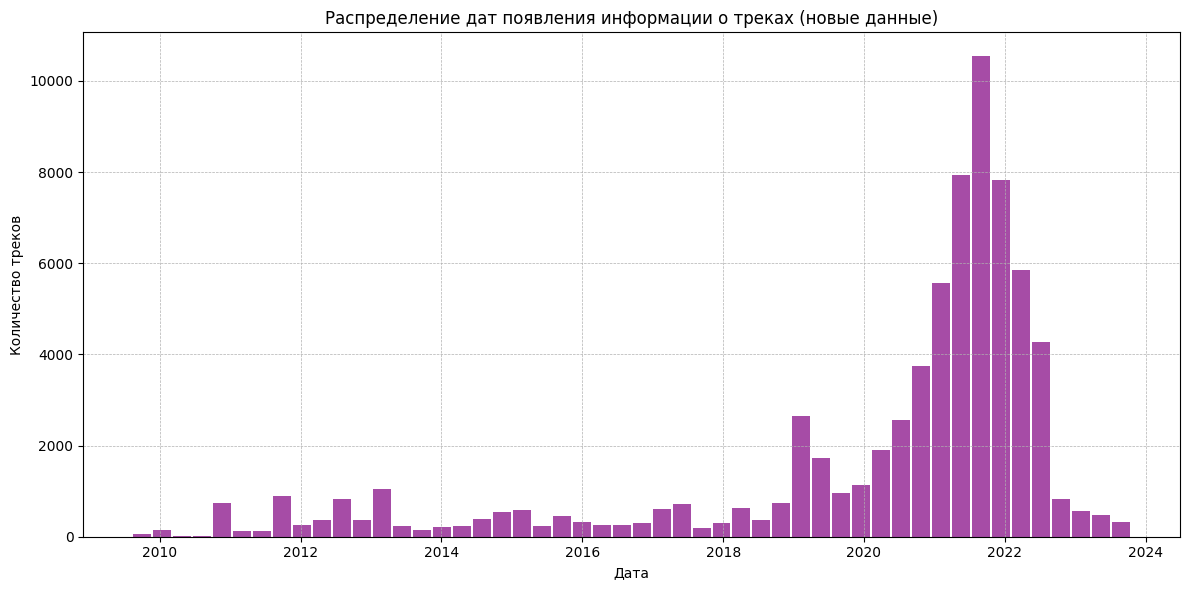

In [25]:
# Оставляем только дату, без времени
merged1_df['dttm'] = merged1_df['dttm'].dt.date

# Построим гистограмму распределения дат появления информации о треках
plt.figure(figsize=(12, 6))
merged1_df['dttm'].hist(bins=50, color='purple', alpha=0.7, rwidth=0.9)
plt.title('Распределение дат появления информации о треках (новые данные)')
plt.xlabel('Дата')
plt.ylabel('Количество треков')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


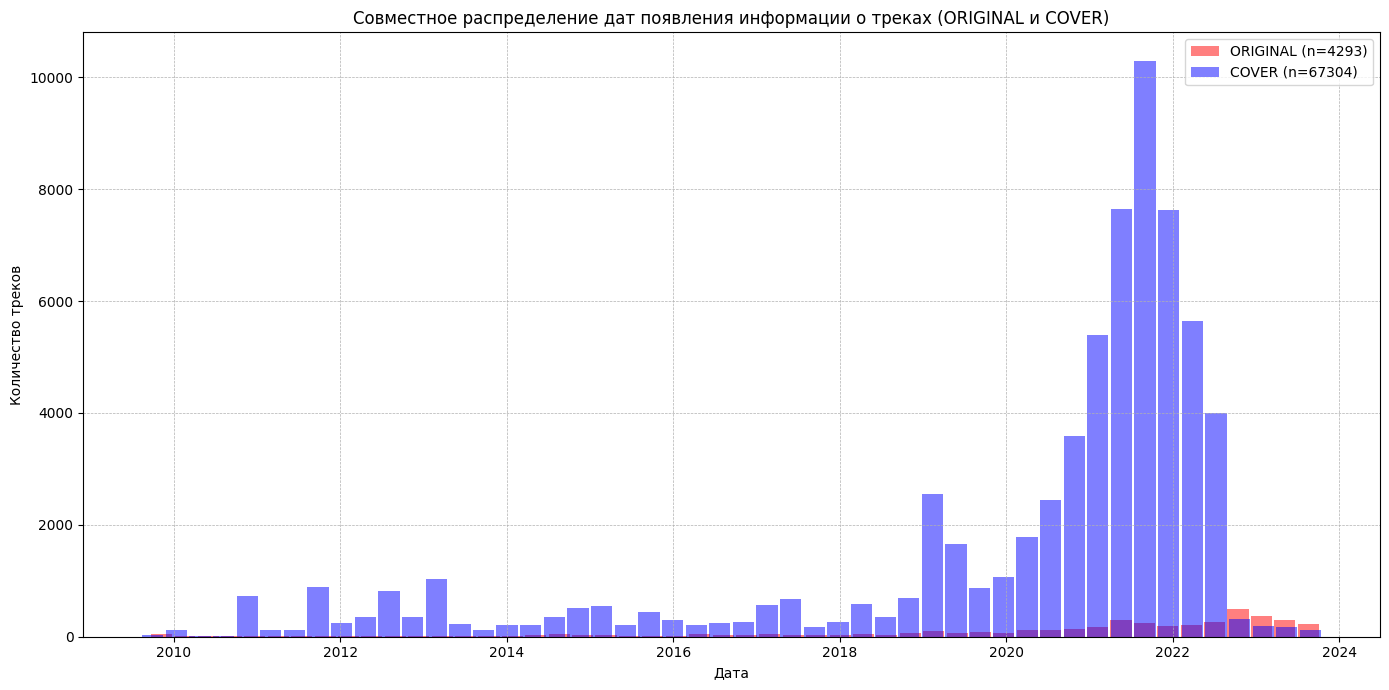

In [26]:
# Отфильтруем данные для треков с меткой ORIGINAL и COVER в новом датафрейме
original_tracks1 = merged1_df[merged1_df['track_remake_type'] == 'ORIGINAL']
cover_tracks1 = merged1_df[merged1_df['track_remake_type'] == 'COVER']

# Построим совместную гистограмму для ORIGINAL и COVER из нового датафрейма
plt.figure(figsize=(14, 7))

# Гистограмма для ORIGINAL из нового датафрейма
original_tracks1['dttm'].hist(bins=50, color='red', alpha=0.5, label=f'ORIGINAL (n={len(original_tracks1)})', rwidth=0.9)
# Гистограмма для COVER из нового датафрейма
cover_tracks1['dttm'].hist(bins=50, color='blue', alpha=0.5, label=f'COVER (n={len(cover_tracks1)})', rwidth=0.9)

plt.title('Совместное распределение дат появления информации о треках (ORIGINAL и COVER)')
plt.xlabel('Дата')
plt.ylabel('Количество треков')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

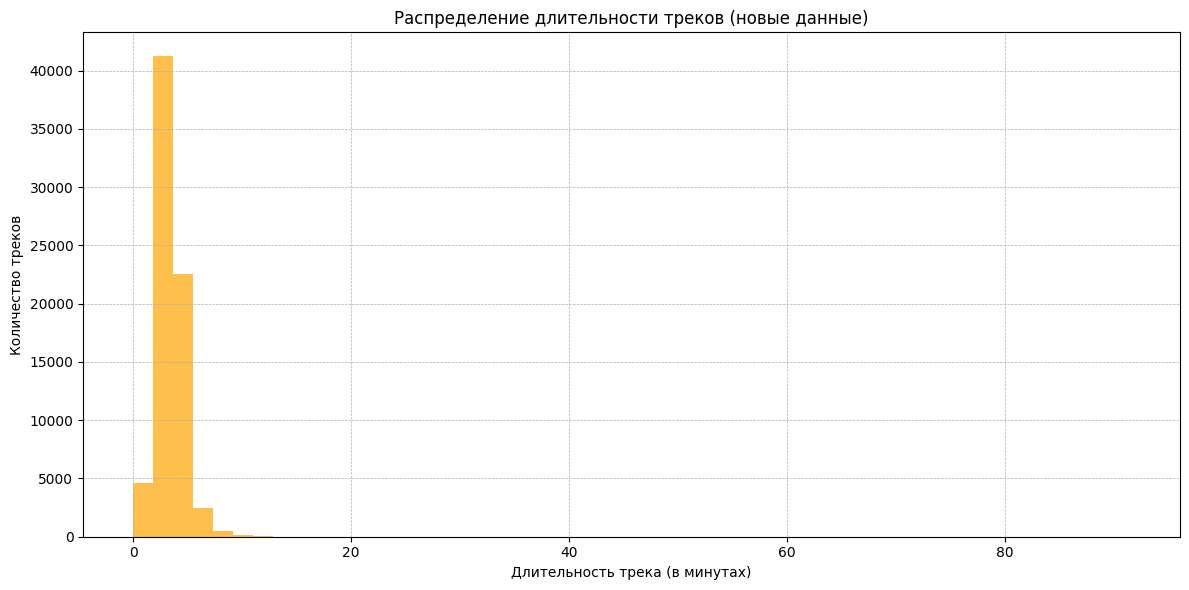

In [27]:
# Построим гистограмму распределения длительности треков из нового датафрейма
# Преобразуем длительность из миллисекунд в минуты для наглядности
merged1_df['duration_minutes'] = merged1_df['duration'] / (60 * 1000)

plt.figure(figsize=(12, 6))
plt.hist(merged1_df['duration_minutes'], bins=50, color='orange', alpha=0.7)
plt.title('Распределение длительности треков (новые данные)')
plt.xlabel('Длительность трека (в минутах)')
plt.ylabel('Количество треков')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

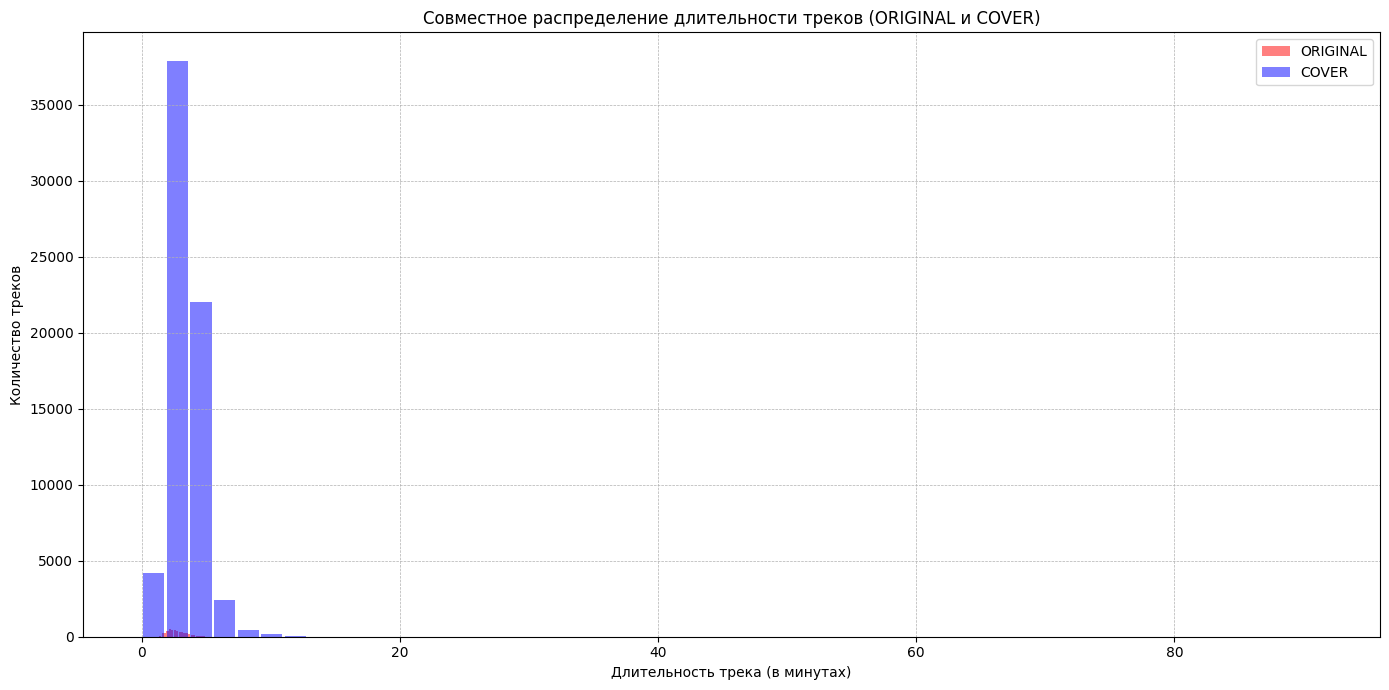

In [28]:
# Построим совместную гистограмму для длительности треков типа ORIGINAL и COVER из нового датафрейма
plt.figure(figsize=(14, 7))

# Гистограмма для длительности треков типа ORIGINAL
merged1_df[merged1_df['track_remake_type'] == 'ORIGINAL']['duration_minutes'].hist(bins=50, color='red', alpha=0.5, label='ORIGINAL', rwidth=0.9)
# Гистограмма для длительности треков типа COVER
merged1_df[merged1_df['track_remake_type'] == 'COVER']['duration_minutes'].hist(bins=50, color='blue', alpha=0.5, label='COVER', rwidth=0.9)

plt.title('Совместное распределение длительности треков (ORIGINAL и COVER)')
plt.xlabel('Длительность трека (в минутах)')
plt.ylabel('Количество треков')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


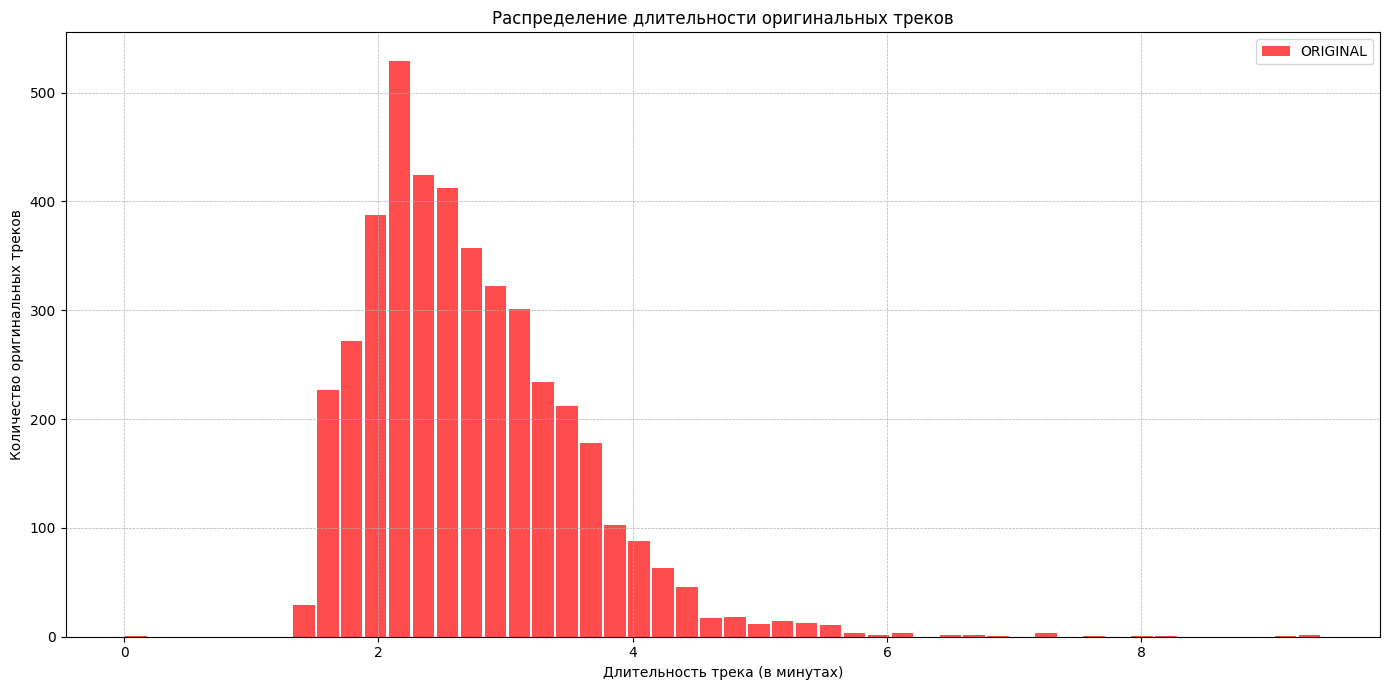

In [29]:
# Построим гистограмму только для длительности треков типа ORIGINAL из нового датафрейма
plt.figure(figsize=(14, 7))

# Гистограмма для длительности треков типа ORIGINAL
merged1_df[merged1_df['track_remake_type'] == 'ORIGINAL']['duration_minutes'].hist(bins=50, color='red', alpha=0.7, rwidth=0.9, label='ORIGINAL')

plt.title('Распределение длительности оригинальных треков')
plt.xlabel('Длительность трека (в минутах)')
plt.ylabel('Количество оригинальных треков')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [30]:
# Отфильтруем треки, длительность которых меньше 10 секунд или больше 6 минут
short_tracks = merged1_df[merged1_df['duration_minutes'] < 6*0.1667]  # 60 секунд в минутах
long_tracks = merged1_df[merged1_df['duration_minutes'] > 6] # больше 6 минут

# Подсчитаем количество оригиналов и каверов для коротких и длинных треков
short_original_count = short_tracks[short_tracks['track_remake_type'] == 'ORIGINAL'].shape[0]
short_cover_count = short_tracks[short_tracks['track_remake_type'] == 'COVER'].shape[0]

long_original_count = long_tracks[long_tracks['track_remake_type'] == 'ORIGINAL'].shape[0]
long_cover_count = long_tracks[long_tracks['track_remake_type'] == 'COVER'].shape[0]

short_original_count, short_cover_count, long_original_count, long_cover_count


(1, 1228, 17, 1997)

1228 треков меньше 1 минуты и в них 1 оригинал
1997 треков больше 6 минут и в их 17 оригиналов (возможно инструменталки)

значения минимальные удалять не будеим не влияет на обучение модели

### Произведем парсинг данных (текст и название трека) по полю "isrc", решение принято на основание того, что это международная кодировка песни и его названия имеют оригинальное значение

### Склейка парсинга с www.deezer.com по isrc

Парсинг производился на нескольких машинах и был разбит на кусочки, чтобы избежать блокировки по ip. Потом все было собрано в один файл. Описание парсинга в отдельной папке

In [65]:
# Создать список имен файлов
file_names = [f"data/result_n{i}.csv" for i in range(1, 101)]

# Читать каждый файл и сохранять содержимое в список датафреймов
dfs = [pd.read_csv(file) for file in file_names]

# Объединить все датафреймы в один
final_df = pd.concat(dfs, ignore_index=True)


In [66]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57429 entries, 0 to 57428
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   isrc    57429 non-null  object
 1   title   57427 non-null  object
 2   lyrics  57429 non-null  object
 3   cav     57429 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


часть данных не была найдена

In [67]:
# Замена строк в колонке "isrc" парсинг выдал их в определенном формате
final_df['isrc'] = final_df['isrc'].str.replace("[\[\]']", "", regex=True)

In [72]:
final_df

isrc                                         title  \
0      USFI86900049     Creedence Clearwater Revival - Proud Mary   
1      USFI86900065  Creedence Clearwater Revival - Fortunate Son   
2      USUL10400965                      Juanes - La Camisa Negra   
3      USUM70722806                     Timbaland - The Way I Are   
4      FR8Q10900116          Yuksek - Extraball (Les Shoes Cover)   
...             ...                                           ...   
57424  RUAGT2312928                     ANNA ASTI - Милый, прощай   
57425  TCAHK2396284                           Triplo Max - Habits   
57426  TCAHM2318975                       Madilyn Bailey - Arcade   
57427  SMRUS0076417                                   Macan - Май   
57428  DGA0M2316512                     Merab Amzoevi - Не улетай   

                                                  lyrics  
0      Left a good job in the city\r\nWorkin' for the...  
1      Some folks are born, made to wave the flag\r\n...  
2      (No por pobre y feo hombre, ¿pero antojao'?)\r...  
3      (State of emergency)\r\nYeah, yeah (yeah)\r\nY...  
4      Now I try to walk and talk \r\nI need the extr...  
...                                                  ...  
57424  Шёл дождь\nЯ будто теряю свой контроль\nБез пя...  
57425                                    текст не найден  
57426                                    текст не найден  
57427                                    текст не найден  
57428                                    текст не найден  

[57429 rows x 3 columns]

в скобках треков указан кавер (по международным стандартам)

In [70]:
# Проверим количество вхождений фразы "текст не найден" в столбце "lyrics" в объединённом датафрейме
not_found_count = final_df[final_df['lyrics'] == "текст не найден"].shape[0]
not_found_count


43674

In [71]:
# Удаляем указанные столбцы из датафрейма проверка общей базы на совпадение с международной, прошло успешно
final_df.drop(columns=['cav'], inplace=True)

In [73]:
merged1_df

original_track_id                          track_id  \
0      eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1      fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2      cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3      995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                                  None  d6288499d0083cc34e60a077b7c4b3e1   
...                                 ...                               ...   
71592  4788e0bf61d80ef5ec9380aa8a8119d9  4788e0bf61d80ef5ec9380aa8a8119d9   
71593                              None  78b2db35476f134dc3cdfbf4d77ba034   
71594                              None  e720ff378efe032df56e0e656a6a92d3   
71595  554e33d79e258da91149c3a4985cf6a1  554e33d79e258da91149c3a4985cf6a1   
71596  7b0f6ff24137be50cf5ea5f82d789448  7b0f6ff24137be50cf5ea5f82d789448   

      track_remake_type        dttm                title language  \
0              ORIGINAL  2009-11-11           Proud Mary       EN   
1              ORIGINAL  2009-11-11        Fortunate Son       EN   
2              ORIGINAL  2009-09-21      La Camisa Negra       ES   
3              ORIGINAL  2009-11-16        The Way I Are       EN   
4                 COVER  2009-09-17            Extraball       EN   
...                 ...         ...                  ...      ...   
71592          ORIGINAL  2023-09-28        Милый, прощай     None   
71593             COVER  2023-10-01  Habits (Stay Hight)       EN   
71594             COVER  2023-10-05               Arcade       EN   
71595          ORIGINAL  2023-10-05                  Май     None   
71596          ORIGINAL  2023-10-05            Не улетай     None   

               isrc                  genres  duration  duration_minutes  
0      USFI86900049         [ROCK, ALLROCK]  187220.0          3.120333  
1      USFI86900065         [ROCK, ALLROCK]  137780.0          2.296333  
2      USUL10400965  [POP, FOLK, LATINFOLK]  216840.0          3.614000  
3      USUM70722806       [FOREIGNRAP, RAP]  179660.0          2.994333  
4      FR8Q10900116           [ELECTRONICS]  212620.0          3.543667  
...             ...                     ...       ...               ...  
71592  RUAGT2312928           [POP, RUSPOP]  178980.0          2.983000  
71593  TCAHK2396284           [ELECTRONICS]  149570.0          2.492833  
71594  TCAHM2318975     [FOREIGNBARD, BARD]  201580.0          3.359667  
71595  SMRUS0076417           [RUSRAP, RAP]  156870.0          2.614500  
71596  DGA0M2316512           [POP, RUSPOP]  148500.0          2.475000  

[71597 rows x 10 columns]

**Соединим данные парсинга и наши данные**

In [77]:
# соединим  merged1_df и final_df
merged_df = pd.merge(merged1_df, final_df, on='isrc', how='left')


In [78]:
merged_df

original_track_id                          track_id  \
0      eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1      fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2      cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3      995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                                  None  d6288499d0083cc34e60a077b7c4b3e1   
...                                 ...                               ...   
71864  4788e0bf61d80ef5ec9380aa8a8119d9  4788e0bf61d80ef5ec9380aa8a8119d9   
71865                              None  78b2db35476f134dc3cdfbf4d77ba034   
71866                              None  e720ff378efe032df56e0e656a6a92d3   
71867  554e33d79e258da91149c3a4985cf6a1  554e33d79e258da91149c3a4985cf6a1   
71868  7b0f6ff24137be50cf5ea5f82d789448  7b0f6ff24137be50cf5ea5f82d789448   

      track_remake_type        dttm              title_x language  \
0              ORIGINAL  2009-11-11           Proud Mary       EN   
1              ORIGINAL  2009-11-11        Fortunate Son       EN   
2              ORIGINAL  2009-09-21      La Camisa Negra       ES   
3              ORIGINAL  2009-11-16        The Way I Are       EN   
4                 COVER  2009-09-17            Extraball       EN   
...                 ...         ...                  ...      ...   
71864          ORIGINAL  2023-09-28        Милый, прощай     None   
71865             COVER  2023-10-01  Habits (Stay Hight)       EN   
71866             COVER  2023-10-05               Arcade       EN   
71867          ORIGINAL  2023-10-05                  Май     None   
71868          ORIGINAL  2023-10-05            Не улетай     None   

               isrc                  genres  duration  duration_minutes  \
0      USFI86900049         [ROCK, ALLROCK]  187220.0          3.120333   
1      USFI86900065         [ROCK, ALLROCK]  137780.0          2.296333   
2      USUL10400965  [POP, FOLK, LATINFOLK]  216840.0          3.614000   
3      USUM70722806       [FOREIGNRAP, RAP]  179660.0          2.994333   
4      FR8Q10900116           [ELECTRONICS]  212620.0          3.543667   
...             ...                     ...       ...               ...   
71864  RUAGT2312928           [POP, RUSPOP]  178980.0          2.983000   
71865  TCAHK2396284           [ELECTRONICS]  149570.0          2.492833   
71866  TCAHM2318975     [FOREIGNBARD, BARD]  201580.0          3.359667   
71867  SMRUS0076417           [RUSRAP, RAP]  156870.0          2.614500   
71868  DGA0M2316512           [POP, RUSPOP]  148500.0          2.475000   

                                            title_y  \
0         Creedence Clearwater Revival - Proud Mary   
1      Creedence Clearwater Revival - Fortunate Son   
2                          Juanes - La Camisa Negra   
3                         Timbaland - The Way I Are   
4              Yuksek - Extraball (Les Shoes Cover)   
...                                             ...   
71864                     ANNA ASTI - Милый, прощай   
71865                           Triplo Max - Habits   
71866                       Madilyn Bailey - Arcade   
71867                                   Macan - Май   
71868                     Merab Amzoevi - Не улетай   

                                                  lyrics  
0      Left a good job in the city\r\nWorkin' for the...  
1      Some folks are born, made to wave the flag\r\n...  
2      (No por pobre y feo hombre, ¿pero antojao'?)\r...  
3      (State of emergency)\r\nYeah, yeah (yeah)\r\nY...  
4      Now I try to walk and talk \r\nI need the extr...  
...                                                  ...  
71864  Шёл дождь\nЯ будто теряю свой контроль\nБез пя...  
71865                                    текст не найден  
71866                                    текст не найден  
71867                                    текст не найден  
71868                                    текст не найден 

База с найдеными isrc

In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71869 entries, 0 to 71868
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4840 non-null   object 
 1   track_id           71869 non-null  object 
 2   track_remake_type  71869 non-null  object 
 3   dttm               71869 non-null  object 
 4   title_x            71869 non-null  object 
 5   language           21962 non-null  object 
 6   isrc               71559 non-null  object 
 7   genres             71869 non-null  object 
 8   duration           71869 non-null  float64
 9   duration_minutes   71869 non-null  float64
 10  title_y            57699 non-null  object 
 11  lyrics             57701 non-null  object 
dtypes: float64(2), object(10)
memory usage: 7.1+ MB


**Осталось решить вопрос с языком**

In [32]:
lyrics_df.head()

lyricId  \
0  a951f9504e89759e9d23039b7b17ec14   
1  0c749bc3f01eb8e6cf986fa14ccfc585   
2  e2c8830fbc86e5964478243099eec23a   
3  e2c8830fbc86e5964478243099eec23a   
4  7624653ca8522ba93470843c74961b7d   

                                                text  \
0  Живу сейчас обломами, обломками не той любви\n...   
1  Tell me your fable\nA fable\nTell me your fabl...   
2  You're ashamed about all your fears and doubts...   
3  You're ashamed about all your fears and doubts...   
4  You showed him all the best of you,\nBut I'm a...   

                           track_id  
0  1c4b1230f937e4c548ff732523214dcd  
1  0faea89b0d7d6235b5b74def72511bd8  
2  9c6dc41d5ccd9968d07f055da5d8f741  
3  bfd04a73e9cffdf0e282c92219a86ea1  
4  8d70930d09cd239c948408d1317d8659

**mergeall_df** итоговая база всех данных, была почищена и преобразанована в отдельный файл для обучения на нескольких машинах, а так же для определения разбиения на оригинал и его каверы

In [36]:
mergeall_df = merged_df.merge(lyrics_df, on='track_id', how='left')


In [35]:
mergeall_df

**Пересборка общего датафрейма**

In [98]:
mergeall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72858 entries, 0 to 72857
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5401 non-null   object 
 1   track_id           72858 non-null  object 
 2   track_remake_type  72858 non-null  object 
 3   dttm               72858 non-null  object 
 4   language           22744 non-null  object 
 5   isrc               72529 non-null  object 
 6   genres             72858 non-null  object 
 7   duration           72858 non-null  float64
 8   lyrics             58608 non-null  object 
 9   lyricId            11297 non-null  object 
 10  text               59828 non-null  object 
 11  title              72858 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.2+ MB


удалим не нужное

In [85]:
# Удаляем указанные столбцы из датафрейма
mergeall_df.drop(columns=['duration_minutes'], inplace=True)

In [88]:
# новый столбец title, который сначала использует значения из title_y, и если они отсутствуют (NaN), то заполняется значениями из title_x.
mergeall_df['title'] = mergeall_df['title_y'].combine_first(mergeall_df['title_x'])


In [97]:
mergeall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72858 entries, 0 to 72857
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5401 non-null   object 
 1   track_id           72858 non-null  object 
 2   track_remake_type  72858 non-null  object 
 3   dttm               72858 non-null  object 
 4   language           22744 non-null  object 
 5   isrc               72529 non-null  object 
 6   genres             72858 non-null  object 
 7   duration           72858 non-null  float64
 8   lyrics             58608 non-null  object 
 9   lyricId            11297 non-null  object 
 10  text               59828 non-null  object 
 11  title              72858 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.2+ MB


In [91]:
# Удаляем указанные столбцы из датафрейма
mergeall_df.drop(columns=['title_x','title_y'], inplace=True)

In [93]:

# Заменяем пустые значения в столбце 'text' значениями из столбца 'lyrics'
mergeall_df['text'] = mergeall_df['text'].combine_first(mergeall_df['lyrics'])


In [95]:
# Проверим количество вхождений фразы "текст не найден" в столбце "lyrics" в объединённом датафрейме
not_found_count = mergeall_df[mergeall_df['text'] == "текст не найден"].shape[0]
not_found_count

39696

In [99]:
# Удаляем указанные столбцы из датафрейма
mergeall_df.drop(columns=['lyrics'], inplace=True)

In [110]:
# Заменяем строки "текст не найден" на NaN в столбцах 'lyrics' и 'text'

mergeall_df['text'] = mergeall_df['text'].replace("текст не найден", np.nan)

In [118]:
mergeall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72858 entries, 0 to 72857
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5401 non-null   object 
 1   track_id           72858 non-null  object 
 2   track_remake_type  72858 non-null  object 
 3   dttm               72858 non-null  object 
 4   language           22744 non-null  object 
 5   isrc               72529 non-null  object 
 6   genres             72858 non-null  object 
 7   duration           72858 non-null  float64
 8   lyricId            11297 non-null  object 
 9   text               20132 non-null  object 
 10  title              72858 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.1+ MB


In [103]:
# Преобразование всех значений в столбце 'genres' к строковому формату
mergeall_df['genres'] = mergeall_df['genres'].astype(str)

# Выводим первые 10 уникальных значений столбца 'genres'
unique_genres_samples_all = mergeall_df['genres'].unique()[:10]
unique_genres_samples_all


array(["['ROCK', 'ALLROCK']", "['POP', 'FOLK', 'LATINFOLK']",
       "['FOREIGNRAP', 'RAP']", "['ELECTRONICS']",
       "['JAZZ', 'VOCALJAZZ']", "['JAZZ']", "['CLASSICMETAL', 'METAL']",
       "['POP', 'ROCK', 'ALLROCK']", "['ELECTRONICS', 'BASSGENRE']",
       "['METAL', 'DOOMMETAL']"], dtype=object)

In [119]:
# Подсчитываем количество уникальных значений в столбце 'genres'
unique_genres_count_all = mergeall_df['genres'].nunique()
unique_genres_count_all


229

In [125]:
# Находим дубликаты в столбце 'track_id'
duplicated_track_ids = mergeall_df[mergeall_df['track_id'].duplicated(keep=False)].sort_values('track_id')

# Выводим строки с дубликатами
len(duplicated_track_ids)


1555

In [122]:

# Группируем по 'track_id' и заполняем пропущенные значения значениями из дубликатов
mergeall_df = mergeall_df.groupby('track_id', group_keys=False).apply(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
).reset_index(drop=True)

# Удаляем дубликаты строк
mergeall_df= mergeall_df.drop_duplicates()



In [126]:
# Удаляем строки, где 'track_id' дублируется, оставляя только первое вхождение
mergeall_df =mergeall_df.drop_duplicates(subset='track_id', keep='first')

In [127]:
# Проверяем размер датафрейма после удаления дубликатов
mergeall_df.shape


(71597, 11)

In [128]:
mergeall_df.head()

original_track_id                          track_id  \
0      eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
2      fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
3      cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
4      995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
8                                  None  d6288499d0083cc34e60a077b7c4b3e1   
...                                 ...                               ...   
72853  4788e0bf61d80ef5ec9380aa8a8119d9  4788e0bf61d80ef5ec9380aa8a8119d9   
72854                              None  78b2db35476f134dc3cdfbf4d77ba034   
72855                              None  e720ff378efe032df56e0e656a6a92d3   
72856  554e33d79e258da91149c3a4985cf6a1  554e33d79e258da91149c3a4985cf6a1   
72857  7b0f6ff24137be50cf5ea5f82d789448  7b0f6ff24137be50cf5ea5f82d789448   

      track_remake_type        dttm language          isrc  \
0              ORIGINAL  2009-11-11       EN  USFI86900049   
2              ORIGINAL  2009-11-11       EN  USFI86900065   
3              ORIGINAL  2009-09-21       ES  USUL10400965   
4              ORIGINAL  2009-11-16       EN  USUM70722806   
8                 COVER  2009-09-17       EN  FR8Q10900116   
...                 ...         ...      ...           ...   
72853          ORIGINAL  2023-09-28     None  RUAGT2312928   
72854             COVER  2023-10-01       EN  TCAHK2396284   
72855             COVER  2023-10-05       EN  TCAHM2318975   
72856          ORIGINAL  2023-10-05     None  SMRUS0076417   
72857          ORIGINAL  2023-10-05     None  DGA0M2316512   

                             genres  duration  \
0               ['ROCK', 'ALLROCK']  187220.0   
2               ['ROCK', 'ALLROCK']  137780.0   
3      ['POP', 'FOLK', 'LATINFOLK']  216840.0   
4             ['FOREIGNRAP', 'RAP']  179660.0   
8                   ['ELECTRONICS']  212620.0   
...                             ...       ...   
72853             ['POP', 'RUSPOP']  178980.0   
72854               ['ELECTRONICS']  149570.0   
72855       ['FOREIGNBARD', 'BARD']  201580.0   
72856             ['RUSRAP', 'RAP']  156870.0   
72857             ['POP', 'RUSPOP']  148500.0   

                                lyricId  \
0      260f21d9f48e8de874a6e844159ddf28   
2      2498827bd11eca5846270487e4960080   
3      5237001311d4062bf2b80de30652bf58   
4      e5b1b57090b728e8d98d2b4d9b781bf4   
8                                   NaN   
...                                 ...   
72853                               NaN   
72854                               NaN   
72855                               NaN   
72856                               NaN   
72857                               NaN   

                                                    text  \
0      Left a good job in the city\nWorkin' for the m...   
2      Some folks are born made to wave the flag\nOoh...   
3      Uno por pobre y feo, hombre\nPero antoja'o, ay...   
4      Yeah!... yeah!... remember the time, baby... y...   
8      Now I try to walk and talk \r\nI need the extr...   
...                                                  ...   
72853  Шёл дождь\nЯ будто теряю свой контроль\nБез пя...   
72854                                                NaN   
72855                                                NaN   
72856                                                NaN   
72857                                                NaN   

                                              title  
0         Creedence Clearwater Revival - Proud Mary  
2      Creedence Clearwater Revival - Fortunate Son  
3                          Juanes - La Camisa Negra  
4                         Timbaland - The Way I Are  
8              Yuksek - Extraball (Les Shoes Cover)  
...                                             ...  
72853                     ANNA ASTI - Милый, прощай  
72854                           Triplo Max - Habits  
72855                       Madilyn Bai

In [130]:
# Сохранение result_df в CSV файл
mergeall_df.to_csv('all_df_dop.csv', index=False)

## Загрузим датасет со спаресенными данными и посмотрим на него 1 вариант! классический ML

In [13]:
deezer_df = pd.read_csv('all_df_dop.csv')

In [14]:
data_info(deezer_df)

Выведем первые и последние 5 строк:


original_track_id                          track_id  \
0      eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1      fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2      cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3      995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                                   NaN  d6288499d0083cc34e60a077b7c4b3e1   
71592  4788e0bf61d80ef5ec9380aa8a8119d9  4788e0bf61d80ef5ec9380aa8a8119d9   
71593                               NaN  78b2db35476f134dc3cdfbf4d77ba034   
71594                               NaN  e720ff378efe032df56e0e656a6a92d3   
71595  554e33d79e258da91149c3a4985cf6a1  554e33d79e258da91149c3a4985cf6a1   
71596  7b0f6ff24137be50cf5ea5f82d789448  7b0f6ff24137be50cf5ea5f82d789448   

      track_remake_type        dttm language          isrc  \
0              ORIGINAL  2009-11-11       EN  USFI86900049   
1              ORIGINAL  2009-11-11       EN  USFI86900065   
2              ORIGINAL  2009-09-21       ES  USUL10400965   
3              ORIGINAL  2009-11-16       EN  USUM70722806   
4                 COVER  2009-09-17       EN  FR8Q10900116   
71592          ORIGINAL  2023-09-28      NaN  RUAGT2312928   
71593             COVER  2023-10-01       EN  TCAHK2396284   
71594             COVER  2023-10-05       EN  TCAHM2318975   
71595          ORIGINAL  2023-10-05      NaN  SMRUS0076417   
71596          ORIGINAL  2023-10-05      NaN  DGA0M2316512   

                             genres  duration  \
0               ['ROCK', 'ALLROCK']  187220.0   
1               ['ROCK', 'ALLROCK']  137780.0   
2      ['POP', 'FOLK', 'LATINFOLK']  216840.0   
3             ['FOREIGNRAP', 'RAP']  179660.0   
4                   ['ELECTRONICS']  212620.0   
71592             ['POP', 'RUSPOP']  178980.0   
71593               ['ELECTRONICS']  149570.0   
71594       ['FOREIGNBARD', 'BARD']  201580.0   
71595             ['RUSRAP', 'RAP']  156870.0   
71596             ['POP', 'RUSPOP']  148500.0   

                                lyricId  \
0      260f21d9f48e8de874a6e844159ddf28   
1      2498827bd11eca5846270487e4960080   
2      5237001311d4062bf2b80de30652bf58   
3      e5b1b57090b728e8d98d2b4d9b781bf4   
4                                   NaN   
71592                               NaN   
71593                               NaN   
71594                               NaN   
71595                               NaN   
71596                               NaN   

                                                    text  \
0      Left a good job in the city\nWorkin' for the m...   
1      Some folks are born made to wave the flag\nOoh...   
2      Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3      Yeah!... yeah!... remember the time, baby... y...   
4      Now I try to walk and talk \r\nI need the extr...   
71592  Шёл дождь\nЯ будто теряю свой контроль\nБез пя...   
71593                                                NaN   
71594                                                NaN   
71595                                                NaN   
71596                                                NaN   

                                              title  
0         Creedence Clearwater Revival - Proud Mary  
1      Creedence Clearwater Revival - Fortunate Son  
2                          Juanes - La Camisa Negra  
3                         Timbaland - The Way I Are  
4              Yuksek - Extraball (Les Shoes Cover)  
71592                     ANNA ASTI - Милый, прощай  
71593                           Triplo Max - Habits  
71594                       Madilyn Bailey - Arcade  
71595                                   Macan - Май  
71596                     Merab Amzoevi - Не улетай


Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71597 non-null  object 
 2   track_remake_type  71597 non-null  object 
 3   dttm               71597 non-null  object 
 4   language           21826 non-null  object 
 5   isrc               71287 non-null  object 
 6   genres             71597 non-null  object 
 7   duration           71597 non-null  float64
 8   lyricId            10123 non-null  object 
 9   text               18940 non-null  object 
 10  title              71597 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.0+ MB


None


Выведем статистическую информацию по датафрейму:


count unique  \
original_track_id     4821   4468   
track_id             71597  71597   
track_remake_type    71597      2   
dttm                 71597   3347   
language             21826     85   
isrc                 71287  71115   
genres               71597    229   
duration           71597.0    NaN   
lyricId              10123   9743   
text                 18940  18026   
title                71597  66971   

                                                                 top   freq  \
original_track_id                   f3e5e9db509f9b6f6d93b9c38e4e1324     38   
track_id                            eeb69a3cb92300456b6a5f4162093851      1   
track_remake_type                                              COVER  67304   
dttm                                                      2013-03-11    838   
language                                                          EN  15194   
isrc                                                    FR33T0819525      3   
genres                                         ['FOLK', 'LATINFOLK']  18391   
duration                                                         NaN    NaN   
lyricId                             28fbafaf626c497d0d4d933b4f0d3f5b      9   
text               Can't be sleepin'\nKeep on waking\nIs that the...     10   
title                                                           Rolê     29   

                            mean          std  min       25%       50%  \
original_track_id            NaN          NaN  NaN       NaN       NaN   
track_id                     NaN          NaN  NaN       NaN       NaN   
track_remake_type            NaN          NaN  NaN       NaN       NaN   
dttm                         NaN          NaN  NaN       NaN       NaN   
language                     NaN          NaN  NaN       NaN       NaN   
isrc                         NaN          NaN  NaN       NaN       NaN   
genres                       NaN          NaN  NaN       NaN       NaN   
duration           204881.707041  85653.33616  0.0  161320.0  199340.0   
lyricId                      NaN          NaN  NaN       NaN       NaN   
text                         NaN          NaN  NaN       NaN       NaN   
title                        NaN          NaN  NaN       NaN       NaN   

                        75%        max  
original_track_id       NaN        NaN  
track_id                NaN        NaN  
track_remake_type       NaN        NaN  
dttm                    NaN        NaN  
language                NaN        NaN  
isrc                    NaN        NaN  
genres                  NaN        NaN  
duration           239040.0  5487300.0  
lyricId                 NaN        NaN  
text                    NaN        NaN  
title                   NaN        NaN


Посмотрим на признаки:
1. original_track_id - тип данных object, уникальных значений: 4469, пропущенных значений: 66776, всего значений: 4821
2. track_id - тип данных object, уникальных значений: 71597, пропущенных значений: 0, всего значений: 71597
3. track_remake_type - тип данных object, уникальных значений: 2, пропущенных значений: 0, всего значений: 71597
4. dttm - тип данных object, уникальных значений: 3347, пропущенных значений: 0, всего значений: 71597
5. language - тип данных object, уникальных значений: 86, пропущенных значений: 49771, всего значений: 21826
6. isrc - тип данных object, уникальных значений: 71116, пропущенных значений: 310, всего значений: 71287
7. genres - тип данных object, уникальных значений: 229, пропущенных значений: 0, всего значений: 71597
8. duration - тип данных float64, уникальных значений: 23581, пропущенных значений: 0, всего значений: 71597
9. lyricId - тип данных object, уникальных значений: 9744, пропущенных значений: 61474, всего значений: 1

original_track_id    66776
track_id                 0
track_remake_type        0
dttm                     0
language             49771
isrc                   310
genres                   0
duration                 0
lyricId              61474
text                 52657
title                    0
dtype: int64


Количество дубликатов: 0


In [15]:
# Сразу объявим переменную с размером датасета для понимания на сколько он 'похудеет' при предобработке
deezer_df_size = deezer_df.shape
deezer_df_size

(71597, 11)

In [16]:
# Выведем строку с индексом 24238, если она существует в данных
row_with_index_24238 = deezer_df[deezer_df.index == 24238]
row_with_index_24238


original_track_id                          track_id track_remake_type  \
24238               NaN  34410f2c44bce8f3805d7312adb89ab8             COVER   

             dttm language          isrc   genres  duration  \
24238  2020-08-21      NaN  QZMZ92010887  ['POP']  241310.0   

                                lyricId  \
24238  5fa954f0329617db058e861d95c6d6db   

                                                    text     title  
24238  'Cause I love you for infinity\nI love you for...  Infinity

In [17]:
# Удалим строку с индексом 6207, где обнаружено бесконечное значение в столбце 'title'
deezer_df.drop(index=24238, inplace=True)

# Проверим ещё раз наличие бесконечных значений после удаления строки
X_train_numeric = deezer_df.apply(pd.to_numeric, errors='coerce')
inf_mask = np.isinf(X_train_numeric.values)
inf_indices = np.where(inf_mask.any(axis=1))[0]

# Выведем количество оставшихся строк с бесконечными значениями
len(inf_indices)


0

In [18]:
# Создадим отчет по сотстоянию датасета на момент загрузки
deez_report = ProfileReport(deezer_df, title="deezer_df report")
deez_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
deezer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71596 entries, 0 to 71596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71596 non-null  object 
 2   track_remake_type  71596 non-null  object 
 3   dttm               71596 non-null  object 
 4   language           21826 non-null  object 
 5   isrc               71286 non-null  object 
 6   genres             71596 non-null  object 
 7   duration           71596 non-null  float64
 8   lyricId            10122 non-null  object 
 9   text               18939 non-null  object 
 10  title              71596 non-null  object 
dtypes: float64(1), object(10)
memory usage: 8.6+ MB


### Предобработка

In [20]:
# Уберем все признаки с id. Они не значительны для машинного обучения
deezer_df = deezer_df.drop(['original_track_id', 'track_id', 'isrc', 'lyricId'], axis=1)

In [21]:
# Преобразуем признак dttm в нормальный формат даты
deezer_df['dttm'] = pd.to_datetime(deezer_df['dttm'])

In [22]:
# В признаке text 52657 пропущенных значений - заполним их значением no_text
deezer_df['text'] = deezer_df['text'].fillna('no_text')

In [23]:
# При помощи рукописной функции заполним пропуски в признаке language по признаку text: если в признаке text содержится no_text, то заполняем значением no_language,
# в противном случае определяем язык
deezer_df['language'] = deezer_df.apply(lambda row: detect_language(row['text']) if pd.isna(row['language']) else row['language'], axis=1)

In [24]:
# Посмотрим, что получилось:
data_info(deezer_df)

Выведем первые и последние 5 строк:


track_remake_type       dttm     language                        genres  \
0              ORIGINAL 2009-11-11           EN           ['ROCK', 'ALLROCK']   
1              ORIGINAL 2009-11-11           EN           ['ROCK', 'ALLROCK']   
2              ORIGINAL 2009-09-21           ES  ['POP', 'FOLK', 'LATINFOLK']   
3              ORIGINAL 2009-11-16           EN         ['FOREIGNRAP', 'RAP']   
4                 COVER 2009-09-17           EN               ['ELECTRONICS']   
71592          ORIGINAL 2023-09-28           ru             ['POP', 'RUSPOP']   
71593             COVER 2023-10-01           EN               ['ELECTRONICS']   
71594             COVER 2023-10-05           EN       ['FOREIGNBARD', 'BARD']   
71595          ORIGINAL 2023-10-05  no_language             ['RUSRAP', 'RAP']   
71596          ORIGINAL 2023-10-05  no_language             ['POP', 'RUSPOP']   

       duration                                               text  \
0      187220.0  Left a good job in the city\nWorkin' for the m...   
1      137780.0  Some folks are born made to wave the flag\nOoh...   
2      216840.0  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3      179660.0  Yeah!... yeah!... remember the time, baby... y...   
4      212620.0  Now I try to walk and talk \r\nI need the extr...   
71592  178980.0  Шёл дождь\nЯ будто теряю свой контроль\nБез пя...   
71593  149570.0                                            no_text   
71594  201580.0                                            no_text   
71595  156870.0                                            no_text   
71596  148500.0                                            no_text   

                                              title  
0         Creedence Clearwater Revival - Proud Mary  
1      Creedence Clearwater Revival - Fortunate Son  
2                          Juanes - La Camisa Negra  
3                         Timbaland - The Way I Are  
4              Yuksek - Extraball (Les Shoes Cover)  
71592                     ANNA ASTI - Милый, прощай  
71593                           Triplo Max - Habits  
71594                       Madilyn Bailey - Arcade  
71595                                   Macan - Май  
71596                     Merab Amzoevi - Не улетай


Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71596 entries, 0 to 71596
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_remake_type  71596 non-null  object        
 1   dttm               71596 non-null  datetime64[ns]
 2   language           71596 non-null  object        
 3   genres             71596 non-null  object        
 4   duration           71596 non-null  float64       
 5   text               71596 non-null  object        
 6   title              71596 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 6.4+ MB


None


Выведем статистическую информацию по датафрейму:


count unique                    top   freq      first  \
track_remake_type    71596      2                  COVER  67303        NaT   
dttm                 71596   3347    2013-03-11 00:00:00    838 2009-08-10   
language             71596    149            no_language  39027        NaT   
genres               71596    229  ['FOLK', 'LATINFOLK']  18391        NaT   
duration           71596.0    NaN                    NaN    NaN        NaT   
text                 71596  18026                no_text  52657        NaT   
title                71596  66970                   Rolê     29        NaT   

                        last           mean           std  min       25%  \
track_remake_type        NaT            NaN           NaN  NaN       NaN   
dttm              2023-10-18            NaN           NaN  NaN       NaN   
language                 NaT            NaN           NaN  NaN       NaN   
genres                   NaT            NaN           NaN  NaN       NaN   
duration                 NaT  204881.198237  85653.826138  0.0  161317.5   
text                     NaT            NaN           NaN  NaN       NaN   
title                    NaT            NaN           NaN  NaN       NaN   

                        50%       75%        max  
track_remake_type       NaN       NaN        NaN  
dttm                    NaN       NaN        NaN  
language                NaN       NaN        NaN  
genres                  NaN       NaN        NaN  
duration           199340.0  239040.0  5487300.0  
text                    NaN       NaN        NaN  
title                   NaN       NaN        NaN


Посмотрим на признаки:
1. track_remake_type - тип данных object, уникальных значений: 2, пропущенных значений: 0, всего значений: 71596
2. dttm - тип данных datetime64[ns], уникальных значений: 3347, пропущенных значений: 0, всего значений: 71596
3. language - тип данных object, уникальных значений: 149, пропущенных значений: 0, всего значений: 71596
4. genres - тип данных object, уникальных значений: 229, пропущенных значений: 0, всего значений: 71596
5. duration - тип данных float64, уникальных значений: 23581, пропущенных значений: 0, всего значений: 71596
6. text - тип данных object, уникальных значений: 18026, пропущенных значений: 0, всего значений: 71596
7. title - тип данных object, уникальных значений: 66970, пропущенных значений: 0, всего значений: 71596

Посмотрим пропуски:


track_remake_type    0
dttm                 0
language             0
genres               0
duration             0
text                 0
title                0
dtype: int64


Количество дубликатов: 201


Мы избавились от пропусков, но появились полные дубликаты. Удалим их.

In [25]:
# Удалим дубликаты, оставив только первое значение
deezer_df.drop_duplicates(inplace=True)

In [26]:
# Посмотрим, что получилось:
deezer_df.duplicated().sum()

0

Пройдемся по признакам

In [27]:
# Создадим признак duration_min c данными по длительности трека в минутах. Возьмем данные из признака duration
# Конвертируем столбец миллисекунд в минуты
deezer_df['duration_min'] = (deezer_df['duration'] / 60000).round(2)

In [28]:
# Посмотрим на распределение признака duration_min
deezer_df['duration_min'].describe()

count    71395.000000
mean         3.415915
std          1.427141
min          0.000000
25%          2.690000
50%          3.320000
75%          3.980000
max         91.460000
Name: duration_min, dtype: float64

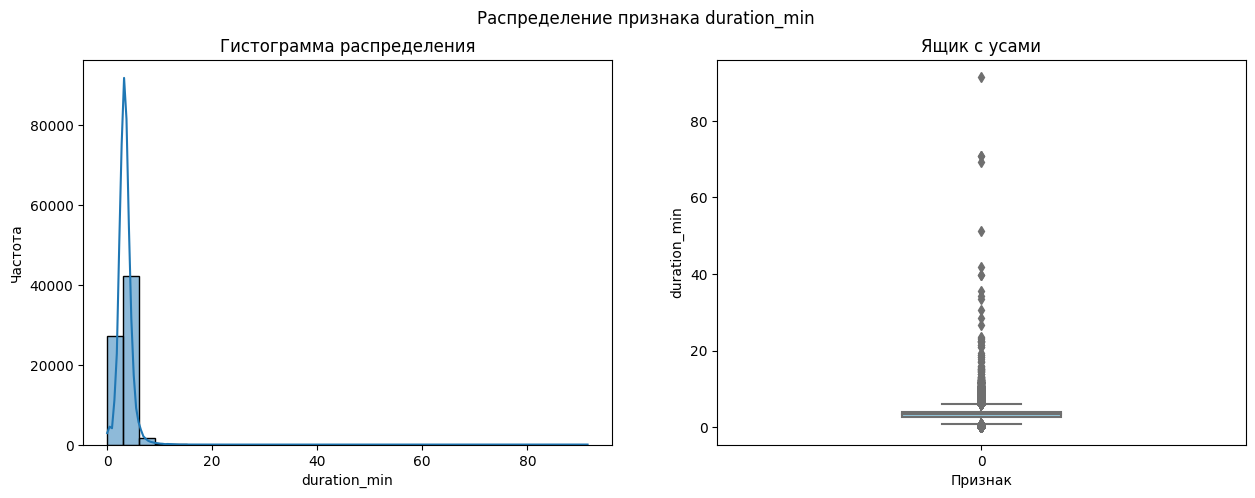

In [29]:
# Построим графики
numeric_hist_boxplot(deezer_df, ['duration_min'])

Из графиков мы видим, что присутствуют треки с длительностью, которые мы можем признать аномальной. Посомтрим на них:

In [30]:
# Посмотрим на треки с длительностью более 50 минут:
deezer_df[deezer_df['duration_min'] > 20]

track_remake_type       dttm     language  \
2195              COVER 2011-11-09           en   
5699              COVER 2013-05-08           EN   
5700              COVER 2013-05-08           EN   
5701              COVER 2013-05-08           EN   
5702              COVER 2013-05-08           EN   
11395             COVER 2017-11-06           EN   
17379             COVER 2019-06-05  no_language   
17380             COVER 2019-06-05  no_language   
17381             COVER 2019-06-05  no_language   
17382             COVER 2019-06-05  no_language   
17633             COVER 2019-07-01  no_language   
20343             COVER 2020-03-01           ID   
20832             COVER 2020-04-14  no_language   
24784             COVER 2020-09-10  no_language   
24790             COVER 2020-09-10  no_language   
24791             COVER 2020-09-10  no_language   
26115             COVER 2020-11-04  no_language   
26959             COVER 2020-11-12  no_language   
26960             COVER 2020-11-12  no_language   
30722             COVER 2021-02-08  no_language   
34890             COVER 2021-04-09  no_language   
41412             COVER 2021-07-05  no_language   
53356             COVER 2021-11-02           ES   
54656             COVER 2021-11-16  no_language   
57606             COVER 2021-12-26  no_language   
67358             COVER 2022-06-23  no_language   

                                genres   duration  \
2195                           ['POP']  1383760.0   
5699         ['NEWAGE', 'ELECTRONICS']  2392090.0   
5700         ['NEWAGE', 'ELECTRONICS']  4256970.0   
5701         ['NEWAGE', 'ELECTRONICS']  2391990.0   
5702         ['NEWAGE', 'ELECTRONICS']  4256800.0   
11395                        ['RELAX']  5487300.0   
17379                    ['SPIRITUAL']  1248420.0   
17380                    ['SPIRITUAL']  1355810.0   
17381                    ['SPIRITUAL']  1253720.0   
17382                    ['SPIRITUAL']  1839230.0   
17633                        ['METAL']  1711710.0   
20343                          ['POP']  3072300.0   
20832              ['ROCK', 'ALLROCK']  1283470.0   
24784          ['REGGAE', 'REGGAETON']  2137880.0   
24790          ['REGGAE', 'REGGAETON']  2057340.0   
24791          ['REGGAE', 'REGGAETON']  2509410.0   
26115              ['EASTERN', 'FOLK']  1337010.0   
26959              ['ROCK', 'ALLROCK']  1403620.0   
26960              ['ROCK', 'ALLROCK']  1335890.0   
30722  ['CLASSICAL', 'CLASSICALMUSIC']  1350960.0   
34890                  ['ELECTRONICS']  1603100.0   
41412            ['FOLK', 'LATINFOLK']  1351010.0   
53356            ['FOLK', 'LATINFOLK']  2008120.0   
54656                         ['FOLK']  1288530.0   
57606            ['FOLK', 'LATINFOLK']  4149510.0   
67358            ['FOLK', 'LATINFOLK']  1404940.0   

                                                    text  \
2195   I got my eyes on you, you're everything that I...   
5699                                             no_text   
5700                                             no_text   
5701                                             no_text   
5702                                             no_text   
11395                                            no_text   
17379                                            no_text   
17380                                            no_text   
17381                                            no_text   
17382                                            no_text   
17633                                            no_text   
20343                                            no_text   
20832                                            no_text   
24784                                            no_text   
24790                                            no_text   
24791                                            no_text   
26115                                            no_text   
26959                                            no_text   
26960                                            no_text

Из таблицы мы можем предположить, что для большинство этих треков - инструментальная музыка. Оставим как есть.

In [31]:
# Посмотрим на треки с длительностью менее 3 секунд:
deezer_df[deezer_df['duration_min'] < 0.05]

track_remake_type       dttm     language  \
1271              COVER 2010-11-10           HI   
2844              COVER 2011-11-18           en   
2845              COVER 2011-11-18           en   
2846              COVER 2011-11-18           en   
3055              COVER 2012-02-23           en   
...                 ...        ...          ...   
69990             COVER 2022-08-13           es   
69991             COVER 2022-08-13           es   
69992             COVER 2022-08-13           es   
69993             COVER 2022-08-13  no_language   
70012             COVER 2022-08-15           EN   

                                genres  duration  \
1271                         ['INDIE']       0.0   
2844   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
2845   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
2846   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
3055           ['FOREIGNBARD', 'BARD']       0.0   
...                                ...       ...   
69990                         ['FOLK']       0.0   
69991                         ['FOLK']       0.0   
69992                         ['FOLK']       0.0   
69993                  ['ALTERNATIVE']       0.0   
70012                          ['RAP']       0.0   

                                                    text  \
1271   Sun Zara Soniye Sun Zara 4\nAaj Khamoshiyon Se...   
2844   My hands shake cause today,\nI know you're gon...   
2845   Something beautiful today is gonna happen\nI c...   
2846   She wraps her tragic moments tightly around he...   
3055   She work it girl, she work the pole\nShe break...   
...                                                  ...   
69990  Corazón de pájaro\n\n(Teresa Parodi - Horacio ...   
69991  Candombe para el que hata ayer reía \n\n(Luis ...   
69992                                       El Malvenido   
69993                                            no_text   
70012                                            no_text   

                                                   title  duration_min  
1271                                            Sun Zara           0.0  
2844   Madina Lake - Here I Stand (AOL Sessions Under...           0.0  
2845      Madina Lake - Today (AOL Sessions Under Cover)           0.0  
2846     Madina Lake - Adalia (AOL Sessions Under Cover)           0.0  
3055                                      Ayo Technology           0.0  
...                                                  ...           ...  
69990  Bárbara Grabinski - Desde el Sur del Litoral (...           0.0  
69991  Bárbara Grabinski - Candombe para el Que Hasta...           0.0  
69992           Bárbara Grabinski - El Malvenido (Cover)           0.0  
69993                                     With Strangers           0.0  
70012                    Ju Major - Baddest (P3RK REMIX)           0.0  

[344 rows x 8 columns]

344 трека длительностью менее 3-х секунд - многовато

In [32]:
# Посмотрим на треки с длительностью 0 секунд:
deezer_df[deezer_df['duration_min'] == 0]

track_remake_type       dttm     language  \
1271              COVER 2010-11-10           HI   
2844              COVER 2011-11-18           en   
2845              COVER 2011-11-18           en   
2846              COVER 2011-11-18           en   
3055              COVER 2012-02-23           en   
...                 ...        ...          ...   
69990             COVER 2022-08-13           es   
69991             COVER 2022-08-13           es   
69992             COVER 2022-08-13           es   
69993             COVER 2022-08-13  no_language   
70012             COVER 2022-08-15           EN   

                                genres  duration  \
1271                         ['INDIE']       0.0   
2844   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
2845   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
2846   ['ALTERNATIVE', 'POSTHARDCORE']       0.0   
3055           ['FOREIGNBARD', 'BARD']       0.0   
...                                ...       ...   
69990                         ['FOLK']       0.0   
69991                         ['FOLK']       0.0   
69992                         ['FOLK']       0.0   
69993                  ['ALTERNATIVE']       0.0   
70012                          ['RAP']       0.0   

                                                    text  \
1271   Sun Zara Soniye Sun Zara 4\nAaj Khamoshiyon Se...   
2844   My hands shake cause today,\nI know you're gon...   
2845   Something beautiful today is gonna happen\nI c...   
2846   She wraps her tragic moments tightly around he...   
3055   She work it girl, she work the pole\nShe break...   
...                                                  ...   
69990  Corazón de pájaro\n\n(Teresa Parodi - Horacio ...   
69991  Candombe para el que hata ayer reía \n\n(Luis ...   
69992                                       El Malvenido   
69993                                            no_text   
70012                                            no_text   

                                                   title  duration_min  
1271                                            Sun Zara           0.0  
2844   Madina Lake - Here I Stand (AOL Sessions Under...           0.0  
2845      Madina Lake - Today (AOL Sessions Under Cover)           0.0  
2846     Madina Lake - Adalia (AOL Sessions Under Cover)           0.0  
3055                                      Ayo Technology           0.0  
...                                                  ...           ...  
69990  Bárbara Grabinski - Desde el Sur del Litoral (...           0.0  
69991  Bárbara Grabinski - Candombe para el Que Hasta...           0.0  
69992           Bárbara Grabinski - El Malvenido (Cover)           0.0  
69993                                     With Strangers           0.0  
70012                    Ju Major - Baddest (P3RK REMIX)           0.0  

[343 rows x 8 columns]

343 трека с нулевой длительностью - возможно это связано с некорректной выгрузкой данных. Стоит уточнить это у заказчика, а пока признаем данные аномальными и удалим.

In [33]:
deezer_df = deezer_df.drop(deezer_df[deezer_df['duration_min'] == 0].index)

In [34]:
# Удалим признак duration, он нам больше не нужен
deezer_df = deezer_df.drop(['duration'], axis=1)

Создадим числовой признак, отражающий разницу между датой добавления песни и начальной датой в днях

In [35]:
# вычисление минимального значения признака 'dttm'
min_dttm = deezer_df['dttm'].min()

# вычисление нового признака 'days_since_start'
deezer_df['days_since_start'] = (deezer_df['dttm'] - min_dttm).dt.days


In [36]:
# Удалим признак dttm, он нам больше не нужен
deezer_df = deezer_df.drop(['dttm'], axis=1)

In [37]:
# Заменим значения "ORIGINAL" на 0 и "COVER" на 1
deezer_df['track_remake_type'] = deezer_df['track_remake_type'].replace({'ORIGINAL': 0, 'COVER': 1})


In [38]:
deezer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71052 entries, 0 to 71596
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  71052 non-null  int64  
 1   language           71052 non-null  object 
 2   genres             71052 non-null  object 
 3   text               71052 non-null  object 
 4   title              71052 non-null  object 
 5   duration_min       71052 non-null  float64
 6   days_since_start   71052 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.3+ MB


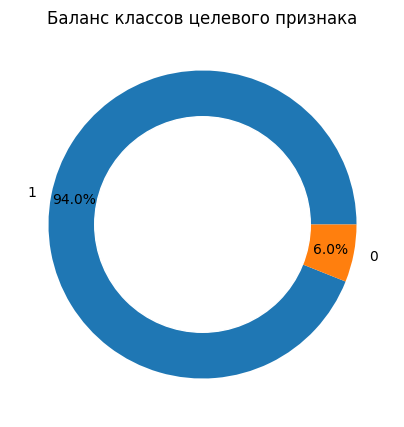

In [39]:
plot_pie_chart(deezer_df, 'track_remake_type', figsize=(5, 5), labeldistance=1.1,
               pctdistance=0.85, fontsize=10, title='Баланс классов целевого признака')

### Потестим модели с TF-IDF только для треков с текстом

In [40]:
# сделаем выборку треков с наличием текста:
df_with_text = deezer_df[deezer_df['text'] != 'no_text']
# Посмотрим размерность:
df_with_text.shape

(18876, 7)

In [51]:
df_with_text.head()

track_remake_type language                        genres  \
0                  0       EN           ['ROCK', 'ALLROCK']   
1                  0       EN           ['ROCK', 'ALLROCK']   
2                  0       ES  ['POP', 'FOLK', 'LATINFOLK']   
3                  0       EN         ['FOREIGNRAP', 'RAP']   
4                  1       EN               ['ELECTRONICS']   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title  duration_min  \
0     Creedence Clearwater Revival - Proud Mary          3.12   
1  Creedence Clearwater Revival - Fortunate Son          2.30   
2                      Juanes - La Camisa Negra          3.61   
3                     Timbaland - The Way I Are          2.99   
4          Yuksek - Extraball (Les Shoes Cover)          3.54   

   days_since_start  
0                93  
1                93  
2                42  
3                98  
4                38

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
# Предполагается, что жанры представлены строками, где каждый жанр разделен запятой
# # Преобразуем строку с жанрами в список жанров
# df_with_text['genres'] = df_with_text['genres'].apply(lambda x: x.split(','))


In [52]:
# Проверяем количество NaN в целевой переменной
df_with_text['track_remake_type'].isna().sum()

0

In [59]:

# Преобразуем строковое представление списка в настоящий список
# Убедитесь, что элементы в строке разделены запятыми
df_with_text['genres'] = df_with_text['genres'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))


In [66]:
df_with_text['genres'].isna().sum()

0

In [67]:
# Инициализируем MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# Преобразуем список жанров в бинарные признаки
genres_encoded = mlb.fit_transform(df_with_text['genres'])

# Создаем DataFrame с бинарными признаками для жанров
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Обязательно устанавливаем тот же индекс, что и в df_with_text
genres_df.index = df_with_text.index

# Объединяем новые признаки жанров с исходным DataFrame
df_with_text_encoded = pd.concat([df_with_text, genres_df], axis=1)

# Удаляем столбец с исходным текстовым полем жанров
df_with_text_encoded.drop('genres', axis=1, inplace=True)

# Проверяем количество NaN в целевой переменной после преобразования
nan_count_after = df_with_text_encoded['track_remake_type'].isna().sum()
print(f"Количество NaN после преобразования: {nan_count_after}")

Количество NaN после преобразования: 0


In [68]:
df_with_text_encoded.head()

track_remake_type language  \
0                  0       EN   
1                  0       EN   
2                  0       ES   
3                  0       EN   
4                  1       EN   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title  duration_min  \
0     Creedence Clearwater Revival - Proud Mary          3.12   
1  Creedence Clearwater Revival - Fortunate Son          2.30   
2                      Juanes - La Camisa Negra          3.61   
3                     Timbaland - The Way I Are          2.99   
4          Yuksek - Extraball (Les Shoes Cover)          3.54   

   days_since_start     AFRICAN  ALLROCK  ALTERNATIVE  ...  TRADJAZZ  TRANCE  \
0                93  0        0        1            0  ...         0       0   
1                93  0        0        1            0  ...         0       0   
2                42  0        0        0            0  ...         0       0   
3                98  0        0        0            0  ...         0       0   
4                38  0        0        0            0  ...         0       0   

   TRIPHOPGENRE  TURKISHROCK  TVSERIES  UKRROCK  UZBEKPOP  VIDEOGAME  VOCAL  \
0             0            0         0        0         0          0      0   
1             0            0         0        0         0          0      0   
2             0            0         0        0         0          0      0   
3             0            0         0        0         0          0      0   
4             0            0         0        0         0          0      0   

   VOCALJAZZ  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 120 columns]

In [69]:
# Проверяем количество NaN в целевой переменной
df_with_text_encoded['track_remake_type'].isna().sum()



0

In [70]:
# Выбор признаков X и целевой переменной y, новые бинарные столбцы для жанров
feature_columns = ['days_since_start', 'language', 'text', 'title', 'duration_min'] + list(mlb.classes_)
X = df_with_text_encoded[feature_columns]
y = df_with_text_encoded['track_remake_type']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

# Проверка размерностей наборов данных
print(
        f'Количество строк и столбцов в обучающей выборке: {X_train.shape}, '
        f'что составляет {X_train.shape[0] / df_with_text_encoded.shape[0]:.2%} от данных.\n'
        f'Доля единиц в обучающем таргете: {sum(y_train == 0) / sum(y_train == 1):.2%}\n'
        f'Количество строк и столбцов в тестовой выборке: {X_test.shape}, '
        f'что составляет {X_test.shape[0] / df_with_text_encoded.shape[0]:.2%} от данных.\n'
        f'Доля единиц в тестовом таргете: {sum(y_test == 0) / sum(y_test == 1):.2%}\n'
)


Количество строк и столбцов в обучающей выборке: (14157, 119), что составляет 75.00% от данных.
Доля единиц в обучающем таргете: 18.31%
Количество строк и столбцов в тестовой выборке: (4719, 119), что составляет 25.00% от данных.
Доля единиц в тестовом таргете: 18.30%



### Сформируем корпус текстов применив метод TF-IDF

In [71]:
# Посмотрим как происходит предобработка текста до и после очистки и лемматизации:
text = X_train.iloc[0]['text']
print(f'Текст до очистки и лемматизации:\n{text}\n\n'
      f'Текст после очистки и лемматизации:\n{preprocess_and_tokenize(text)}')

Текст до очистки и лемматизации:
Oh, I don't know why you're not there
I give you my love, but you don't care
So what is right?
And what is wrong?
Gimme a sign

What is love?
Baby, don't hurt me
Don't hurt me no more
What is love?
Baby, don't hurt me
Don't hurt me no more
(Whoa, whoa, whoa, whoa, oh-whoa, whoa, ohh, ooh)
(Whoa, whoa, whoa, whoa, oh-whoa, whoa, ohh, ooh)

Oh, I don't know, what can I do?
What else can I say, it's up to you
I know we're one
Just me and you
I can't go on

What is love?
Baby, don't hurt me
Don't hurt me no more
What is love?
Baby, don't hurt me
Don't hurt me no more
What is love?
(Whoa, whoa, whoa, whoa, oh-whoa, whoa, ohh, ooh)
(Whoa, whoa, whoa, whoa, oh-whoa, whoa, ohh, ooh)
What is love? What is love? What is love?
What is love? What is love? What is love?

I want no other, no other lover
This is our life, our time
We are together, I need you forever
Is it love?

What is love?
Baby, don't hurt me
Don't hurt me no more
What is love?
Baby, don't hurt me


In [72]:
# Запустим лемматезацию
lemmas_train = {}
lemmas_test = {}

X_train['lemm_text'] = X_train['text'].progress_apply(
    lambda x: preprocess_and_tokenize(x, lemmas_train))
cached_lemmas_test = {}
X_test['lemm_text'] = X_test['text'].progress_apply(
    lambda x: preprocess_and_tokenize(x, lemmas_test))

  0%|          | 0/14157 [00:00<?, ?it/s]

  0%|          | 0/4719 [00:00<?, ?it/s]

In [73]:
# Посмотрим на результат:
X_train[['text', 'lemm_text']].head()

text  \
25848  Oh, I don't know why you're not there\nI give ...   
27272  You've been runnin' round, runnin' round\nRunn...   
64790  После меня\nЧто останется, не потеряй\nЭтот го...   
24949  Me preguntaron que si aún te extraño\nSin titu...   
50487  Loving can hurt, loving can hurt sometimes\nBu...   

                                               lemm_text  
25848  oh don know whi you re not there give my love ...  
27272  you ve been runnin round throwin that dirt all...  
64790  после меня что останется не потеряй этот город...  
24949  me preguntaron que si aún te extraño sin titub...  
50487  love can hurt sometim but it the onli thing th...

In [74]:
# Удалим признак с нелемматизированным текстом
X_train = X_train.drop('text', axis=1)
X_test = X_test.drop('text', axis=1)
# Проверим:
X_train.head()

days_since_start language                                 title  \
25848              4090       EN                  Oneil - What Is Love   
27272              4118       EN                    Reason - Attention   
64790              4658       ru                            После меня   
24949              4054       es  La Herencia - Y Te Vi Con El (cover)   
50487              4438       en    Los Harmonics - Photograph (Cover)   

       duration_min     AFRICAN  ALLROCK  ALTERNATIVE  ALTERNATIVEMETAL  \
25848          2.96  0        0        0            0                 0   
27272          4.08  0        0        0            0                 0   
64790          3.76  0        0        0            0                 0   
24949          3.12  0        0        0            0                 0   
50487          1.70  0        0        0            0                 0   

       AMBIENTGENRE  ...  TRANCE  TRIPHOPGENRE  TURKISHROCK  TVSERIES  \
25848             0  ...       0             0            0         0   
27272             0  ...       0             0            0         0   
64790             0  ...       0             0            0         0   
24949             0  ...       0             0            0         0   
50487             0  ...       0             0            0         0   

       UKRROCK  UZBEKPOP  VIDEOGAME  VOCAL  VOCALJAZZ  \
25848        0         0          0      0          0   
27272        0         0          0      0          0   
64790        0         0          0      0          0   
24949        0         0          0      0          0   
50487        0         0          0      0          0   

                                               lemm_text  
25848  oh don know whi you re not there give my love ...  
27272  you ve been runnin round throwin that dirt all...  
64790  после меня что останется не потеряй этот город...  
24949  me preguntaron que si aún te extraño sin titub...  
50487  love can hurt sometim but it the onli thing th...  

[5 rows x 119 columns]

In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14157 entries, 25848 to 50586
Columns: 119 entries, days_since_start to lemm_text
dtypes: float64(1), int32(114), int64(1), object(3)
memory usage: 6.8+ MB


In [76]:
X_train.columns

Index(['days_since_start', 'language', 'title', 'duration_min', '', 'AFRICAN',
       'ALLROCK', 'ALTERNATIVE', 'ALTERNATIVEMETAL', 'AMBIENTGENRE',
       ...
       'TRANCE', 'TRIPHOPGENRE', 'TURKISHROCK', 'TVSERIES', 'UKRROCK',
       'UZBEKPOP', 'VIDEOGAME', 'VOCAL', 'VOCALJAZZ', 'lemm_text'],
      dtype='object', length=119)

In [77]:
# Проверим наличие NaN значений во всем DataFrame
nan_exists = X_train.isna().any().any()

# Преобразуем все столбцы к числовым, игнорируем ошибки преобразования
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')

# Теперь найдем индексы бесконечных значений среди числовых столбцов
inf_exists = np.isinf(X_train_numeric.select_dtypes(include=[np.number])).any().any()

# Выводим информацию о наличии NaN и бесконечных значений
nan_exists, inf_exists


(False, False)

#### Подготовим данные к обучению моделей

In [78]:
# # Определение типов признаков
# text_features = 'lemm_text'
# categorical_features = ['title', 'language', 'genres']
# numeric_features = ['duration_min', 'days_since_start']

In [79]:
# После применения MultiLabelBinarizer
text_features = 'lemm_text'
categorical_features = ['title', 'language']  # 'genres' убран из списка

# Столбцы жанров, созданные MultiLabelBinarizer
genre_features = list(mlb.classes_)

# Нумерические признаки остаются прежними
numeric_features = ['duration_min', 'days_since_start']

### Обучение

Возьмем для обучения следующие модели:

- XGBClassifier
- LightGBMClassifier
- CatboostClassifier

Подберем гипрепараметры при помощи RandomizedSearchCV, посчитаем на тренировочных данных на кросс-валидации метрики и выберем лучшую модель

In [80]:
# Создадим таблицу с результатами обучения моделей:
result_table = pd.DataFrame(columns=['Mодель', 'Гиперпараметры', 'AUC-ROC на train'])

#### XGBClassifier

In [81]:
# # Создание корпусов слов
 corpus_train = X_train[text_features].values.astype('U')
# corpus_test = X_test[text_features].values.astype('U')

In [88]:
# Создание пайплайнов
text_pipeline = Pipeline([('tfidf_vectorizer', TfidfVectorizer(max_features=10))])
categorical_pipeline = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])
numeric_pipeline = Pipeline([('scaler', StandardScaler())])

# # Сборка предобработчика
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('text', text_pipeline, text_features),
#         ('categorical', categorical_pipeline, categorical_features),
#         ('numeric', numeric_pipeline, numeric_features)
#     ]
# )

# Теперь при создании пайплайна или ColumnTransformer  genre_features в качестве части категориальных признаков

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, text_features),
        ('categorical', categorical_pipeline, categorical_features),
        ('genres', OneHotEncoder(handle_unknown='ignore'), genre_features),
        ('numeric', numeric_pipeline, numeric_features)
    ]
)


In [89]:
# Сборка пайплайна с предобработчиком и моделью
model = XGBClassifier(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Параметры для подбора в GridSearchCV
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0]
}

In [90]:
try:
    xgbc_result, best_model = test_model(
        X_train, y_train, pipeline, param_dist,
        scoring='roc_auc', verbose=10
    )
    print(xgbc_result)
except Exception as e:
    print(f"An error occurred during model testing: {e}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'Модель': 'XGBClassifier', 'Гиперпараметры': {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}, 'Лучшая метрика (AUC)': 0.960316849550952}


In [91]:
best_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf_vectorizer',
                                                                   TfidfVectorizer(max_features=10))]),
                                                  'lemm_text'),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['title', 'language']),
                                                 ('genres',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['', 'AFRICAN', 'ALLROCK',
                                                   'ALTER...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

Модель: XGBClassifier
ROC-AUC на тестовой выборке: 0.9704
F1-скор на тестовой выборке: 0.9653
Резмер тестовой выборки: (4719,)


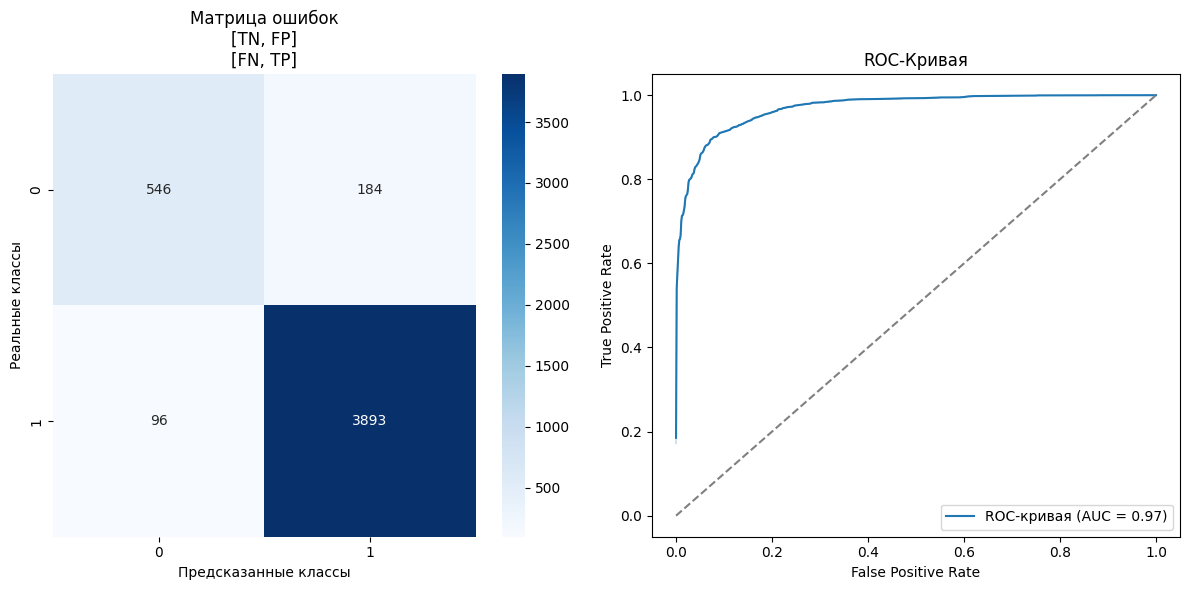

In [93]:
# Используйте 'best_model' для преобразования и предсказания на тестовом наборе данных
# Это автоматически применит 'preprocessor' с уже обученным 'TfidfVectorizer'
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)[:, 1]

# Теперь можно использовать функцию 'evaluate_model'
evaluate_model(best_model, X_test, y_test)  # 'X_test' должен быть сырыми данными, не обработанными 'preprocessor'

In [94]:
# Проверяем, что модель уже обучена
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    # Используем встроенный атрибут feature_importances_ для модели XGBClassifier
    feature_importances = best_model.named_steps['model'].feature_importances_
    # Если модель обучалась на предобработанных данных с использованием Pipeline,
    # признаки будут представлены в трансформированном виде.
    # Для отображения важности признаков в оригинальном пространстве признаков,
    # необходимо использовать имена признаков после преобразования.

    # Получаем имена признаков после ColumnTransformer
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

    # Создаем DataFrame с важностью признаков
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Выводим DataFrame
    print(importances)
else:
    print("Модель не содержит информацию о важности признаков или не обучена.")


                                                 Feature  Importance
14234                                   genres__RUSRAP_1    0.242267
14231                                   genres__RUSPOP_0    0.172996
14233                                   genres__RUSRAP_0    0.147690
14232                                   genres__RUSPOP_1    0.074887
6                                              text__que    0.024775
...                                                  ...         ...
4797               categorical__title_HIM - Solitary Man    0.000000
4798                categorical__title_HIM - Wicked Game    0.000000
4799                categorical__title_HIM - Wicked game    0.000000
4800   categorical__title_HISTORIA NUEVA - Dime la Ve...    0.000000
7139   categorical__title_Lola & Matías - La Vie en R...    0.000000

[14278 rows x 2 columns]


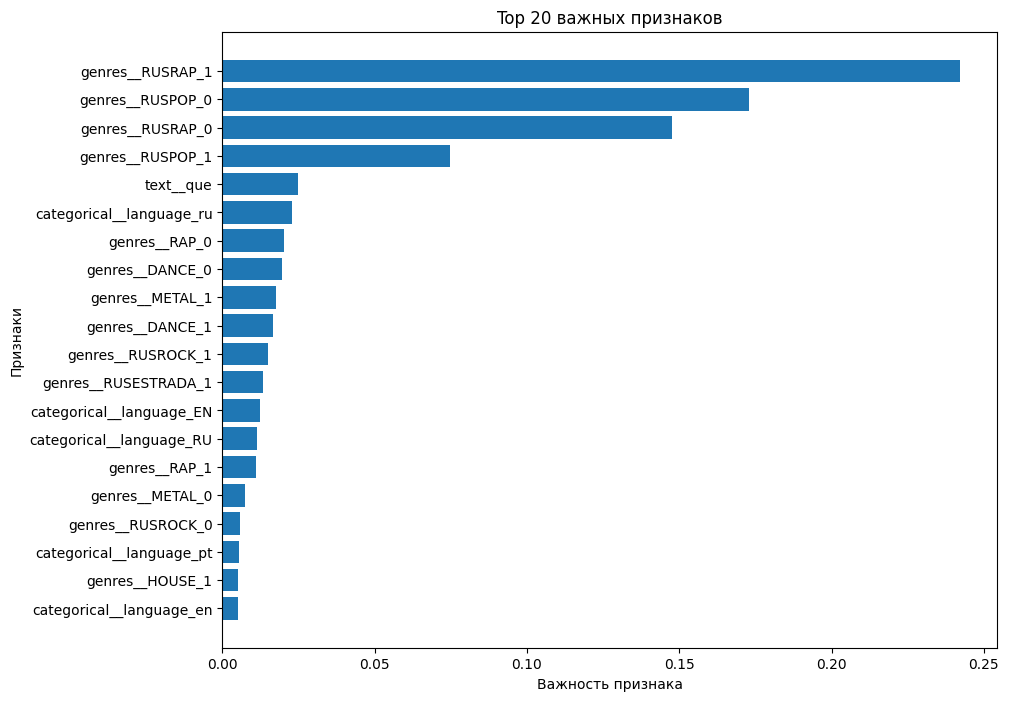

In [95]:
import matplotlib.pyplot as plt

# Предполагаем, что feature_importances и feature_names уже определены
# Создаем DataFrame для удобства отображения
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Ограничим количество признаков для отображения для улучшения читаемости графика
top_features = df_feature_importances.head(20)

# Создание графика
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Top 20 важных признаков')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самые важные признаки были наверху
plt.show()


{'Mодель': 'XGBClassifier',
 'Гиперпараметры': {'model__subsample': 0.8,
  'model__n_estimators': 300,
  'model__max_depth': 7,
  'model__learning_rate': 0.1,
  'model__colsample_bytree': 0.8},
 'AUC-ROC на train': 0.9883}

<div class="alert alert-warning">
Хорошо бы добавить наблюдения, анализ полученных результатов, выводы 😉</div>



## 2 второй вариант решения задачи через NLP

In [96]:
# Загрузим новый предоставленный датафрейм
all_df = pd.read_csv('all_df_dop.csv')

In [97]:
all_df.head()


original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                               NaN  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type        dttm language          isrc  \
0          ORIGINAL  2009-11-11       EN  USFI86900049   
1          ORIGINAL  2009-11-11       EN  USFI86900065   
2          ORIGINAL  2009-09-21       ES  USUL10400965   
3          ORIGINAL  2009-11-16       EN  USUM70722806   
4             COVER  2009-09-17       EN  FR8Q10900116   

                         genres  duration                           lyricId  \
0           ['ROCK', 'ALLROCK']  187220.0  260f21d9f48e8de874a6e844159ddf28   
1           ['ROCK', 'ALLROCK']  137780.0  2498827bd11eca5846270487e4960080   
2  ['POP', 'FOLK', 'LATINFOLK']  216840.0  5237001311d4062bf2b80de30652bf58   
3         ['FOREIGNRAP', 'RAP']  179660.0  e5b1b57090b728e8d98d2b4d9b781bf4   
4               ['ELECTRONICS']  212620.0                               NaN   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title  
0     Creedence Clearwater Revival - Proud Mary  
1  Creedence Clearwater Revival - Fortunate Son  
2                      Juanes - La Camisa Negra  
3                     Timbaland - The Way I Are  
4          Yuksek - Extraball (Les Shoes Cover)

In [98]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71597 non-null  object 
 2   track_remake_type  71597 non-null  object 
 3   dttm               71597 non-null  object 
 4   language           21826 non-null  object 
 5   isrc               71287 non-null  object 
 6   genres             71597 non-null  object 
 7   duration           71597 non-null  float64
 8   lyricId            10123 non-null  object 
 9   text               18940 non-null  object 
 10  title              71597 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.0+ MB


In [99]:
# Удаляем указанные столбцы из датафрейма
all_df.drop(columns=['track_id','original_track_id','lyricId'], inplace=True)

In [100]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  71597 non-null  object 
 1   dttm               71597 non-null  object 
 2   language           21826 non-null  object 
 3   isrc               71287 non-null  object 
 4   genres             71597 non-null  object 
 5   duration           71597 non-null  float64
 6   text               18940 non-null  object 
 7   title              71597 non-null  object 
dtypes: float64(1), object(7)
memory usage: 4.4+ MB


In [101]:
# # Убедимся, что 'dttm' преобразован в формат даты и времени
all_df['dttm'] = pd.to_datetime(all_df['dttm'])

In [102]:
# Найти самое раннее значение в поле 'dttm'
earliest_date = all_df['dttm'].min()
earliest_date

Timestamp('2009-08-10 00:00:00')

In [103]:
# Вычислить "время жизни" для каждой строки
all_df['time'] = all_df['dttm'] - earliest_date


перведем в число ( день или час)

In [104]:
# Преобразуем 'time' в целочисленное количество дней
all_df['time_days'] =all_df['time'].dt.days

In [105]:
all_df.head()


track_remake_type       dttm language          isrc  \
0          ORIGINAL 2009-11-11       EN  USFI86900049   
1          ORIGINAL 2009-11-11       EN  USFI86900065   
2          ORIGINAL 2009-09-21       ES  USUL10400965   
3          ORIGINAL 2009-11-16       EN  USUM70722806   
4             COVER 2009-09-17       EN  FR8Q10900116   

                         genres  duration  \
0           ['ROCK', 'ALLROCK']  187220.0   
1           ['ROCK', 'ALLROCK']  137780.0   
2  ['POP', 'FOLK', 'LATINFOLK']  216840.0   
3         ['FOREIGNRAP', 'RAP']  179660.0   
4               ['ELECTRONICS']  212620.0   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title    time  time_days  
0     Creedence Clearwater Revival - Proud Mary 93 days         93  
1  Creedence Clearwater Revival - Fortunate Son 93 days         93  
2                      Juanes - La Camisa Negra 42 days         42  
3                     Timbaland - The Way I Are 98 days         98  
4          Yuksek - Extraball (Les Shoes Cover) 38 days         38

In [106]:
# Удаляем указанные столбцы из датафрейма
all_df.drop(columns=['dttm','time'], inplace=True)

In [107]:
# Удаляем указанные столбцы из датафрейма
all_df.drop(columns=['isrc'], inplace=True)

Заполним пропуски с языком

In [108]:
!pip install langdetect
from langdetect import detect


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<div class="alert alert-warning">
Импорты надо отнесты в начало тетрадки. А зависимости – в requirements</div>



In [109]:
# Предполагая, что у вас уже есть датафрейм all_df с колонкой 'text'
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'  # Возвращает 'Unknown' если не удается определить язык

# Создаем новый столбец 'detected_language' с результатами определения языка
all_df['detected_language'] = all_df['text'].apply(detect_language)

# Заменяем пустые значения в столбце 'language' на результат определения языка
all_df['language'] = all_df['language'].fillna(all_df['detected_language'])



In [110]:
# Подсчет количества строк со значением 'Unknown' в столбце 'language'
unknown_count = all_df['language'].value_counts().get('Unknown', 0)
unknown_count


39027

In [111]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  71597 non-null  object 
 1   language           71597 non-null  object 
 2   genres             71597 non-null  object 
 3   duration           71597 non-null  float64
 4   text               18940 non-null  object 
 5   title              71597 non-null  object 
 6   time_days          71597 non-null  int64  
 7   detected_language  71597 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.4+ MB


# Разделим нашу музыку на 2 части ( с текстом и без, инструментальная)

In [112]:
# Разделяем датафрейм all_df на две части

# all1_df содержит строки, где есть значения в столбце 'text'
all1_df = all_df[pd.notna(all_df['text'])]

# all2_df содержит строки, где нет значений в столбце 'text'
all2_df = all_df[pd.isna(all_df['text'])]

all1_df.shape, all2_df.shape

((18940, 8), (52657, 8))

сохраним для загрузки и обсчета модели в колаб( с более мощной картой)

In [113]:
# Сохранение result_df в CSV файл
all1_df.to_csv('text_song.csv', index=False)

In [114]:
all2_df.head()

track_remake_type language                  genres  duration text  \
14              COVER       EN  ['METAL', 'DOOMMETAL']  629910.0  NaN   
29              COVER  Unknown                ['JAZZ']  239620.0  NaN   
38              COVER  Unknown                ['JAZZ']  240950.0  NaN   
61              COVER  Unknown                ['JAZZ']  162530.0  NaN   
127             COVER  Unknown               ['DANCE']  242050.0  NaN   

                                                 title  time_days  \
14                             Reverend Bizarre - Bend        969   
29    Stanley Turrentine - Have You Ever Seen The Rain         38   
38   Shelly Berg Trio - She's Always A Woman (Album...        154   
61                           Oliver Nelson - Yesterday        154   
127                                Love Journey Deluxe          0   

    detected_language  
14            Unknown  
29            Unknown  
38            Unknown  
61            Unknown  
127           Unknown

In [115]:
# Разделяем столбец 'title' на два новых столбца 'artist' и 'song', ограничивая количество разделений до 1
all2_df[['artist', 'song']] = all2_df['title'].str.split(' - ', n=1, expand=True)

# Удаляем столбец 'title' из датафрейма all_df
all2_df = all2_df.drop(columns=['title'])



Сохраним так же в отдельный файл нашу "музыку без текста"

In [116]:
# Сохранение result_df в CSV файл
all2_df.to_csv('instr.csv', index=False)

In [117]:
all1_df.shape

(18940, 8)

In [118]:
all1_df.head()

track_remake_type language                        genres  duration  \
0          ORIGINAL       EN           ['ROCK', 'ALLROCK']  187220.0   
1          ORIGINAL       EN           ['ROCK', 'ALLROCK']  137780.0   
2          ORIGINAL       ES  ['POP', 'FOLK', 'LATINFOLK']  216840.0   
3          ORIGINAL       EN         ['FOREIGNRAP', 'RAP']  179660.0   
4             COVER       EN               ['ELECTRONICS']  212620.0   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title  time_days detected_language  
0     Creedence Clearwater Revival - Proud Mary         93                en  
1  Creedence Clearwater Revival - Fortunate Son         93                en  
2                      Juanes - La Camisa Negra         42                es  
3                     Timbaland - The Way I Are         98                en  
4          Yuksek - Extraball (Les Shoes Cover)         38                en

In [119]:
# Функция для очистки текста от всех спецсимволов, оставляя только слова
def clean_text(text):
    return ' '.join(re.findall(r'\b\w+\b', text))

# Применяем функцию очистки к столбцу 'text' в датафрейме all1_df
all1_df['text'] = all1_df['text'].apply(clean_text)


In [120]:
# Удаляем указанные столбцы из датафрейма
all1_df.drop(columns=['detected_language'], inplace=True)

In [121]:
all1_df.head()

track_remake_type language                        genres  duration  \
0          ORIGINAL       EN           ['ROCK', 'ALLROCK']  187220.0   
1          ORIGINAL       EN           ['ROCK', 'ALLROCK']  137780.0   
2          ORIGINAL       ES  ['POP', 'FOLK', 'LATINFOLK']  216840.0   
3          ORIGINAL       EN         ['FOREIGNRAP', 'RAP']  179660.0   
4             COVER       EN               ['ELECTRONICS']  212620.0   

                                                text  \
0  Left a good job in the city Workin for the man...   
1  Some folks are born made to wave the flag Ooh ...   
2  Uno por pobre y feo hombre Pero antoja o ay om...   
3  Yeah yeah remember the time baby yeah I ain t ...   
4  Now I try to walk and talk I need the extra ba...   

                                          title  time_days  
0     Creedence Clearwater Revival - Proud Mary         93  
1  Creedence Clearwater Revival - Fortunate Son         93  
2                      Juanes - La Camisa Negra         42  
3                     Timbaland - The Way I Are         98  
4          Yuksek - Extraball (Les Shoes Cover)         38

In [122]:
# Проверяю, доступна ли видеокарта
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU доступна')
    print('Устройство:', torch.cuda.get_device_name())

    # Выводим информацию о видеопамяти
    total_mem = torch.cuda.get_device_properties(device).total_memory
    reserved_mem = torch.cuda.memory_reserved(device)
    allocated_mem = torch.cuda.memory_allocated(device)
    free_mem = total_mem - reserved_mem

    print('Всего памяти: ', round(total_mem / 1024**3, 2), 'GB')
    print('Используется памяти: ', round(allocated_mem / 1024**3, 2), 'GB')
    print('Зарезервировано памяти: ', round(reserved_mem / 1024**3, 2), 'GB')
    print('Свободной памяти: ', round(free_mem / 1024**3, 2), 'GB')
else:
    device = torch.device('cpu')
    print('GPU не доступна, используется CPU')

cuda
GPU доступна
Устройство: NVIDIA GeForce RTX 3070
Всего памяти:  8.0 GB
Используется памяти:  0.0 GB
Зарезервировано памяти:  0.0 GB
Свободной памяти:  8.0 GB


In [123]:
all1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18940 entries, 0 to 71592
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  18940 non-null  object 
 1   language           18940 non-null  object 
 2   genres             18940 non-null  object 
 3   duration           18940 non-null  float64
 4   text               18940 non-null  object 
 5   title              18940 non-null  object 
 6   time_days          18940 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 1.2+ MB


In [124]:
# кодируем целевую
all1_df['track_remake_type'] = all1_df['track_remake_type'].replace({'COVER': 1, 'ORIGINAL': 0})


In [125]:
all1_df.shape

(18940, 7)

In [165]:

# Проверяем количество NaN в целевой переменной до преобразования
nan_count_before = all1_df['track_remake_type'].isna().sum()
print(f"Количество NaN до преобразования: {nan_count_before}")

# Преобразуем жанры в список, если они представлены строкой
all1_df['genres'] = all1_df['genres'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Инициализируем MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Преобразуем список жанров в бинарные признаки
genres_encoded = mlb.fit_transform(all1_df['genres'])

# Создаем DataFrame с бинарными признаками для жанров
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Обязательно устанавливаем тот же индекс, что и в all1_df
genres_df.index = all1_df.index

# Объединяем новые признаки жанров с исходным DataFrame
df_with_text_encoded = pd.concat([all1_df, genres_df], axis=1)

# Удаляем столбец с исходным текстовым полем жанров
df_with_text_encoded.drop('genres', axis=1, inplace=True)

# Проверяем количество NaN в целевой переменной после преобразования
nan_count_after = df_with_text_encoded['track_remake_type'].isna().sum()
print(f"Количество NaN после преобразования: {nan_count_after}")


Количество NaN до преобразования: 0


AttributeError: 'list' object has no attribute 'strip'

In [166]:
df_with_text_encoded.head()

track_remake_type language  duration  \
0                  0       EN  187220.0   
1                  0       EN  137780.0   
2                  0       ES  216840.0   
3                  0       EN  179660.0   
4                  1       EN  212620.0   

                                                text  \
0  Left a good job in the city Workin for the man...   
1  Some folks are born made to wave the flag Ooh ...   
2  Uno por pobre y feo hombre Pero antoja o ay om...   
3  Yeah yeah remember the time baby yeah I ain t ...   
4  Now I try to walk and talk I need the extra ba...   

                                          title  time_days     AFRICAN  \
0     Creedence Clearwater Revival - Proud Mary         93  0        0   
1  Creedence Clearwater Revival - Fortunate Son         93  0        0   
2                      Juanes - La Camisa Negra         42  0        0   
3                     Timbaland - The Way I Are         98  0        0   
4          Yuksek - Extraball (Les Shoes Cover)         38  0        0   

   ALLROCK  ALTERNATIVE  ...  TRADJAZZ  TRANCE  TRIPHOPGENRE  TURKISHROCK  \
0        1            0  ...         0       0             0            0   
1        1            0  ...         0       0             0            0   
2        0            0  ...         0       0             0            0   
3        0            0  ...         0       0             0            0   
4        0            0  ...         0       0             0            0   

   TVSERIES  UKRROCK  UZBEKPOP  VIDEOGAME  VOCAL  VOCALJAZZ  
0         0        0         0          0      0          0  
1         0        0         0          0      0          0  
2         0        0         0          0      0          0  
3         0        0         0          0      0          0  
4         0        0         0          0      0          0  

[5 rows x 120 columns]

In [167]:
# размер семпла (локально часть данных) на колаб все
sam=2000

In [168]:
#обрежем
data = df_with_text_encoded.sample(sam).reset_index(drop=True)
data

track_remake_type language  duration  \
0                     1       id  269370.0   
1                     1       FR  130900.0   
2                     1       EN  271690.0   
3                     1       pt  230940.0   
4                     1       ru  147690.0   
...                 ...      ...       ...   
1995                  1       id  259780.0   
1996                  1       es  258610.0   
1997                  1       pt  190480.0   
1998                  0       RU  134140.0   
1999                  1       pt  174700.0   

                                                   text  \
0     Hey Jude don t make it bad Take a sad song and...   
1     Donne moi ton cœur baby Ton corps baby hey Don...   
2     Brother brother Sister sister It s the lonelin...   
3     Eu faço o chão tremer yeah De um jeito que nem...   
4     В этом мире я гость непрошеный Отовсюду здесь ...   
...                                                 ...   
1995  Mengapa kau pergi mengapa kau pergi Disaat aku...   
1996  Un día cualquiera de un año cualquiera Hay una...   
1997  Chorando eu fiquei Quando me deixou Estou com ...   
1998  Davia Я снова один в этом Lambo Я снова курю и...   
1999  Uma noite como esta tinha que se repetir É uma...   

                                                  title  time_days     \
0     The Buddha Lounge Ensemble - Hey Jude (Cover V...        820  0   
1                        Emma Peters - Femme Like U (J)       4196  0   
2                               Northern Kings - Killer        175  0   
3     FLIP the creator - Eu Faço o Chão Tremer (Sexy...       4560  0   
4                                   m.ars - Это здорово       4903  0   
...                                                 ...        ... ..   
1995   Jovan - Disaat Aku Mencintaimu (Accoustic Cover)       3717  0   
1996         Suicidal Memories - Invasión Zombi (Cover)       4376  0   
1997           Banda Dupla Paixão - Fica Comigo (Cover)       4406  0   
1998                      Егор Крид - We Gotta Get Love       4728  0   
1999            Alvino Luz - Não, Não Vá Embora (Cover)       4343  0   

      AFRICAN  ALLROCK  ALTERNATIVE  ...  TRADJAZZ  TRANCE  TRIPHOPGENRE  \
0           0        0            0  ...         0       0             0   
1           0        0            0  ...         0       0             0   
2           0        0            0  ...         0       0             0   
3           0        0            0  ...         0       0             0   
4           0        0            0  ...         0       0             0   
...       ...      ...          ...  ...       ...     ...           ...   
1995        0        0            0  ...         0       0             0   
1996        0        0            0  ...         0       0             0   
1997        0        0            0  ...         0       0             0   
1998        0        0            0  ...         0       0             0   
1999        0        0            0  ...         0       0             0   

      TURKISHROCK  TVSERIES  UKRROCK  UZBEKPOP  VIDEOGAME  VOCAL  VOCALJAZZ  
0               0         0        0         0          0      0          0  
1               0         0        0         0          0      0          0  
2               0         0        0         0          0      0          0  
3               0         0        0         0          0      0          0  
4               0         0        0         0          0      0          0  
...           ...       ...      ...       ...        ...    ...        ...  
1995            0         0        0         0          0      0          0  
1996            0         0        0         0          0      0          0  
1997            0         0        0         0          0      0          0  
1998            0         0        0         0          0      0          0  
1999            0         0        0         0          0      0          0  

[2000 rows x 120 

In [169]:
# Загрузите модель и токенизатор
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


# tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
# model = transformers.AutoModel.from_pretrained('bert-base-uncased')

# Создаем классификатор на основе модели BERT
class BertForSequenceClassification(transformers.BertPreTrainedModel):
    # Конструктор класса
    def __init__(self, config):
        # Вызов конструктора родительского класса и инициализация с конфигурацией BERT
        super().__init__(config)
        # Число классов задается из конфигурации BERT
        self.num_labels = config.num_labels

        self.bert = model  # используйте загруженную модель BERT
        # Создание слоя dropout с заданной в конфигурации вероятностью
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        # Создание классификатора как полносвязного слоя
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

     # Определение прямого прохода модели
    def forward(
        self,
        input_ids=None,            # Идентификаторы токенов входных данных
        attention_mask=None,       # Маска внимания для входных данных
        token_type_ids=None,       # Идентификаторы типов токенов для входных данных
        position_ids=None,         # Идентификаторы позиций для входных данных
        head_mask=None,            # Маска для скрытия некоторых голов внимания
        inputs_embeds=None,        # Предварительно встроенные представления входных данных
        labels=None,               # Метки для вычисления функции потерь
        output_attentions=None,    # Флаг, определяющий, следует ли возвращать внимание
        output_hidden_states=None, # Флаг, определяющий, следует ли возвращать скрытое состояние
        return_dict=None,          # Флаг, определяющий, следует ли возвращать данные в виде словаря
    ):
        # Если return_dict не предоставлен, используется значение из конфигурации
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        # Прямой проход через модель BERT
        outputs = self.bert(

            input_ids,                      # Идентификаторы токенов входных данных
            attention_mask=attention_mask,  # Маска внимания для входных данных
            token_type_ids=token_type_ids,  # Идентификаторы типов токенов для входных данных
            position_ids=position_ids,      # Идентификаторы позиций для входных данных
            head_mask=head_mask,            # Маска для скрытия некоторых голов внимания
            inputs_embeds=inputs_embeds,    # Предварительно встроенные представления входных данных
            output_attentions=output_attentions,        # Флаг, определяющий, следует ли возвращать внимание
            output_hidden_states=output_hidden_states,  # Флаг, определяющий, следует ли возвращать скрытое состояние
            return_dict=return_dict,        # Флаг, определяющий, следует ли возвращать данные в виде словаряattention_mask=attention_mask,

        )
        # Извлечение выхода пула из выходов BERT
        pooled_output = outputs[1]
        # Применение dropout к выходу пула
        pooled_output = self.dropout(pooled_output)
        # Пропускание выхода пула через классификатор
        logits = self.classifier(pooled_output)

         # Если предоставлены метки, вычисление потерь
        if labels is not None:
            # Если число меток равно 1, то задача регрессии
            if self.num_labels == 1:
                # задача регрессии
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # Используем кросс-энтропию для вычисления потери в задаче классификации
                loss_fct = torch.nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            # Если не нужно возвращать словарь, то возвращаем кортеж из потерь, логитов и других выходных данных
            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            # Иначе возвращаем выходные данные в виде объекта SequenceClassifierOutput
            return transformers.modeling_outputs.SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        # Если метки не предоставлены, то просто возвращаем логиты и другие выходные данные
        if not return_dict:
            output = (logits,) + outputs[2:]
            return output
        # Иначе возвращаем выходные данные в виде объекта SequenceClassifierOutput
        return transformers.modeling_outputs.SequenceClassifierOutput(
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Используйте классификатор
model = BertForSequenceClassification(model.config)

# Теперь вы можете использовать свой классификатор в процессе обучен

loading configuration file config.json from cache at C:\Users\admin/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at C:\Users\admin/.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\pytorch_model.bin
Some weights 

In [170]:
# Параметры и слои
for name, param in model.named_parameters():
    print(name, param.size())

bert.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder

In [171]:
 # Определение класса CustomDataset, который наследуется от класса Dataset в PyTorch
class CustomDataset(Dataset):

    # Определение функции __init__, которая выполняется при создании объекта CustomDataset
    # Эта функция принимает два аргумента: encodings и labels
    def __init__(self, encodings, labels):
        # Сохранение данных кодирования и меток в переменных экземпляра класса
        self.encodings = encodings
        self.labels = labels

    # Определение функции __getitem__, которая выполняется при получении элемента датасета по индексу
    def __getitem__(self, idx):
        # Формирование элемента датасета, преобразовывая все значения в тензоры PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Добавление метки для данного элемента
        item['labels'] = torch.tensor(self.labels[idx])
        # Возвращение сформированного элемента
        return item

    # Определение функции __len__, которая возвращает количество элементов в датасете
    def __len__(self):
        return len(self.labels)

In [172]:
# Разделение данных на обучающую, валидационную и тестовую выборки
train_data, remaining = train_test_split(data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(remaining, test_size=0.5, random_state=42)

In [173]:
train_data.shape,valid_data.shape,test_data.shape

((1600, 120), (200, 120), (200, 120))

In [174]:
# ТОкинезация длинна 512 и все возвращаем в вектора pyTorch
train_encodings = tokenizer(train_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
valid_encodings = tokenizer(valid_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
test_encodings = tokenizer(test_data['text'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')




In [175]:
train_labels = train_data['track_remake_type'].to_list()
valid_labels = valid_data['track_remake_type'].to_list()
test_labels = test_data['track_remake_type'].to_list()

In [176]:
# дата сеты для тренера
train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [177]:
# train_labels

In [178]:
#чуть переделел чтобы логи и график сходимости сделать
training_args = TrainingArguments(
    output_dir='./results',                  # директория для вывода результатов
    num_train_epochs=2,                      # общее количество эпох обучения
    per_device_train_batch_size=8,          # размер пакета данных на каждом устройстве во время обучения
    per_device_eval_batch_size=32,           # размер пакета данных на каждом устройстве во время оценки
    warmup_steps=500,                        # количество шагов разогрева для планировщика скорости обучения
    weight_decay=0.01,                       # сила убывания веса
    logging_dir='./logs',                    # директория для хранения журналов
    load_best_model_at_end=True,             # загрузка тренировочной модели для теста
    logging_steps=10,                        # журнал и сохранение весов каждые `logging_steps`
    evaluation_strategy='steps',             # оценка  регистрируется при каждом  `logging_steps`
    save_strategy='steps',                   # контрольные точки модели сохраняются  `logging_steps`
    save_steps=500,                          # контрольные точки модели сохраняются каждые `save_steps`
)

using `logging_steps` to initialize `eval_steps` to 10
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [179]:
# # Функция метрики
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score': f1_score(y_true=labels, y_pred=predictions, average='weighted')}  #eval_f1_score': 0.982536356633333
    #return {'f1_score': f1_score(y_true=labels, y_pred=predictions, average='micro')}  #eval_f1_score': 0.9733333333333334

In [180]:
from sklearn.metrics import roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Вычисление вероятностей
    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    # Выбор вероятности положительного класса
    positive_probs = probabilities[:, 1]
    # Вычисление ROC-AUC
    roc_auc = roc_auc_score(y_true=labels, y_score=positive_probs)
    return {'roc_auc': roc_auc}


In [181]:
# тренер
trainer = Trainer(
    model=model,                         # инициированная модель  Transformers, которую требуется обучить
    args=training_args,                   # определенные выше аргументы обучения
    train_dataset=train_dataset,         # обучающий датасет
    eval_dataset=valid_dataset,          # датасет для оценки(валидации)
    compute_metrics=compute_metrics,    # функция обратного вызова, которая вычисляет интересующие нас метрики
)

Тренеруем , тут логи пишутся еще на внешний сервис wandb
метрика f1

In [182]:
# тренеруем модель
trainer.train()

***** Running training *****
  Num examples = 1600
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 400
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evalua

TrainOutput(global_step=400, training_loss=0.29868118464946747, metrics={'train_runtime': 320.8053, 'train_samples_per_second': 9.975, 'train_steps_per_second': 1.247, 'total_flos': 841955377152000.0, 'train_loss': 0.29868118464946747, 'epoch': 2.0})

In [161]:
# валидируем
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 0.5246856212615967,
 'eval_roc_auc': 0.8960679518992174,
 'eval_runtime': 3.1605,
 'eval_samples_per_second': 63.281,
 'eval_steps_per_second': 2.215,
 'epoch': 2.0}

**размер семпла  sam= all**
per_device_train_batch_size=16,
per_device_eval_batch_size=256

{'eval_loss': 0.2674258053302765,
 'eval_f1_score': 0.9104375524106376,
 'eval_runtime': 10.7906,
 'eval_samples_per_second': 111.208,
 'eval_steps_per_second': 3.522,
 'epoch': 8.0}
cuda NVIDIA A100-SXM4-40GB 39.56 GB



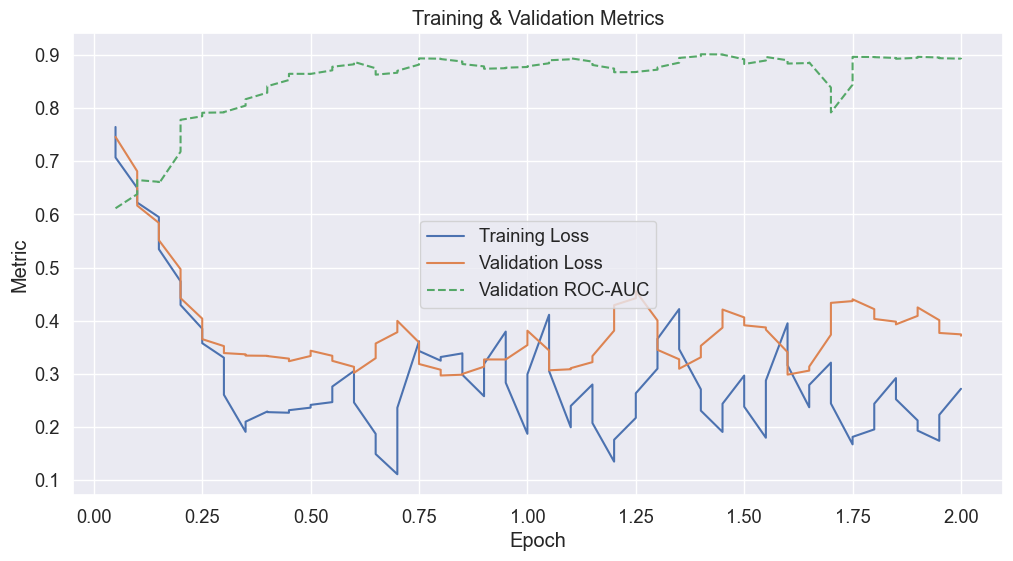

In [183]:
import pandas as pd
import matplotlib.pyplot as plt

# Создаем DataFrame из логов
log_df = pd.DataFrame(trainer.state.log_history)

# Интерполируем пропущенные значения в логах
log_df.interpolate(method='linear', inplace=True)

# Построение графика потерь
plt.figure(figsize=(12, 6))
plt.plot(log_df['epoch'], log_df['loss'], label='Training Loss')
plt.plot(log_df['epoch'], log_df['eval_loss'], label='Validation Loss')

# Построение графика ROC-AUC, если он присутствует в логах
if 'eval_roc_auc' in log_df.columns:
    plt.plot(log_df['epoch'], log_df['eval_roc_auc'], label='Validation ROC-AUC', linestyle='--')

# Настройка заголовка и легенды графика
plt.title('Training & Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

# Отображение графика
plt.show()


In [184]:
predictions = trainer.predict(test_dataset)


***** Running Prediction *****
  Num examples = 200
  Batch size = 32


In [185]:

y_pred = np.argmax(predictions.predictions, axis=1)


In [186]:
y_true = test_labels


<Figure size 1000x1000 with 0 Axes>

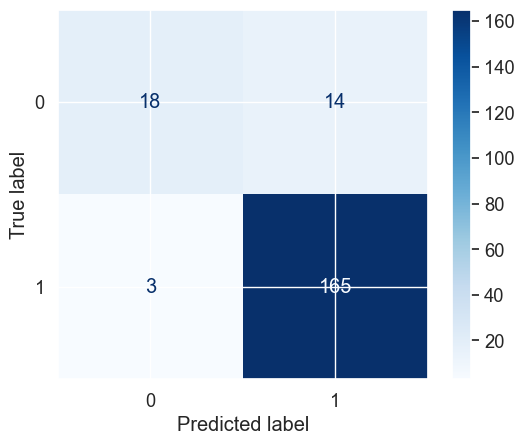

In [187]:
# Вычисление матрицы ошибок
cm = confusion_matrix(y_true, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Кластерезация по данным только с текстом  96% и выше значения совпадения

In [188]:
data = pd.read_csv('all_df_dop.csv')

In [14]:
data.head()

original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                               NaN  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type        dttm language          isrc  \
0          ORIGINAL  2009-11-11       EN  USFI86900049   
1          ORIGINAL  2009-11-11       EN  USFI86900065   
2          ORIGINAL  2009-09-21       ES  USUL10400965   
3          ORIGINAL  2009-11-16       EN  USUM70722806   
4             COVER  2009-09-17       EN  FR8Q10900116   

                         genres  duration                           lyricId  \
0           ['ROCK', 'ALLROCK']  187220.0  260f21d9f48e8de874a6e844159ddf28   
1           ['ROCK', 'ALLROCK']  137780.0  2498827bd11eca5846270487e4960080   
2  ['POP', 'FOLK', 'LATINFOLK']  216840.0  5237001311d4062bf2b80de30652bf58   
3         ['FOREIGNRAP', 'RAP']  179660.0  e5b1b57090b728e8d98d2b4d9b781bf4   
4               ['ELECTRONICS']  212620.0                               NaN   

                                                text  \
0  Left a good job in the city\nWorkin' for the m...   
1  Some folks are born made to wave the flag\nOoh...   
2  Uno por pobre y feo, hombre\nPero antoja'o, ay...   
3  Yeah!... yeah!... remember the time, baby... y...   
4  Now I try to walk and talk \r\nI need the extr...   

                                          title  
0     Creedence Clearwater Revival - Proud Mary  
1  Creedence Clearwater Revival - Fortunate Son  
2                      Juanes - La Camisa Negra  
3                     Timbaland - The Way I Are  
4          Yuksek - Extraball (Les Shoes Cover)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  4821 non-null   object 
 1   track_id           71597 non-null  object 
 2   track_remake_type  71597 non-null  object 
 3   dttm               71597 non-null  object 
 4   language           21826 non-null  object 
 5   isrc               71287 non-null  object 
 6   genres             71597 non-null  object 
 7   duration           71597 non-null  float64
 8   lyricId            10123 non-null  object 
 9   text               18940 non-null  object 
 10  title              71597 non-null  object 
dtypes: float64(1), object(10)
memory usage: 6.0+ MB


In [28]:
def clean_text(text):
    # Проверяем, является ли входное значение строкой
    if isinstance(text, str):
        return ' '.join(re.findall(r'\b\w+\b', text))
    else:
        # Возвращаем пустую строку или исходное значение
        return ''

# Применяем функцию очистки к столбцу 'text' в датафрейме
data['text'] = data['text'].apply(clean_text)

In [29]:
data.head()

original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                               NaN  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type        dttm language          isrc  \
0          ORIGINAL  2009-11-11       EN  USFI86900049   
1          ORIGINAL  2009-11-11       EN  USFI86900065   
2          ORIGINAL  2009-09-21       ES  USUL10400965   
3          ORIGINAL  2009-11-16       EN  USUM70722806   
4             COVER  2009-09-17       EN  FR8Q10900116   

                         genres  duration                           lyricId  \
0           ['ROCK', 'ALLROCK']  187220.0  260f21d9f48e8de874a6e844159ddf28   
1           ['ROCK', 'ALLROCK']  137780.0  2498827bd11eca5846270487e4960080   
2  ['POP', 'FOLK', 'LATINFOLK']  216840.0  5237001311d4062bf2b80de30652bf58   
3         ['FOREIGNRAP', 'RAP']  179660.0  e5b1b57090b728e8d98d2b4d9b781bf4   
4               ['ELECTRONICS']  212620.0                               NaN   

                                                text  \
0  Left a good job in the city Workin for the man...   
1  Some folks are born made to wave the flag Ooh ...   
2  Uno por pobre y feo hombre Pero antoja o ay om...   
3  Yeah yeah remember the time baby yeah I ain t ...   
4  Now I try to walk and talk I need the extra ba...   

                                          title  
0     Creedence Clearwater Revival - Proud Mary  
1  Creedence Clearwater Revival - Fortunate Son  
2                      Juanes - La Camisa Negra  
3                     Timbaland - The Way I Are  
4          Yuksek - Extraball (Les Shoes Cover)

In [30]:

# Установка порога сходства
similarity_threshold = 0.96

# Фильтрация оригинальных треков и каверов
originals = data[data['track_remake_type'] == 'ORIGINAL']
covers = data[data['track_remake_type'] == 'COVER']

# Векторизация текстов песен
vectorizer = TfidfVectorizer()
originals_vectors = vectorizer.fit_transform(originals['text'].dropna())
covers_vectors = vectorizer.transform(covers['text'].dropna())

# Определение наиболее похожих оригиналов для каждого кавера
similarity_scores = cosine_similarity(covers_vectors, originals_vectors)

In [31]:
# Группировка каверов с их оригинальными треками
grouped_covers = {}
for cover_idx, similarities in enumerate(similarity_scores):
    cover = covers.iloc[cover_idx]
    original_idx = np.argmax(similarities)
    max_similarity = similarities[original_idx]

    # Проверка порога сходства
    if max_similarity >= similarity_threshold:
        original = originals.iloc[original_idx]

        # Группировка каверов с оригинальными треками
        if original['track_id'] not in grouped_covers:
            grouped_covers[original['track_id']] = {'original': original['title'], 'covers': []}
        grouped_covers[original['track_id']]['covers'].append(cover['title'])

# Вывод информации о группировке
for original_id, group in grouped_covers.items():
    print(f"Original: {group['original']}")
    print(f"Covers:")
    for cover in group['covers']:
        print(f"- {cover}")
    print("\n")


Original: Michael Jackson - Smooth Criminal (Radio Edit)
Covers:
- Alien Ant Farm - Smooth Criminal
- Alien Ant Farm - Smooth Criminal (Re-Recorded)
- Smooth Criminals - Smooth Criminal
- Alien Ant Farm - Smooth Criminal
- Glee Cast - Smooth Criminal (Glee Cast Version) (feat. 2CELLOS)
- Pellek - Smooth Criminal


Original: Bob Dylan - Knockin' on Heaven's Door
Covers:
- Guns N' Roses - Knockin' On Heaven's Door
- Neimo - Knockin' On Heaven's Door
- Gaby Gabo - Knockin' On Heaven's Door (Cover)
- André Pulga - Knockin on Heaven's Door (Cover)


Original: Creedence Clearwater Revival - Proud Mary
Covers:
- Johnny Hallyday - Proud Mary (Live au Palais des sports 2006)
- Liza Everson - Proud Mary
- Elvis Presley - Proud Mary (Remastered Version)
- Urselle - Proud Mary
- The Love Motion - Proud Mary (Cover Version)
- Tom Jones - Proud Mary
- Mystic Prophecy - Proud Mary
- Glee Cast - Proud Mary (Cover of Creedence Clearwater Revival)
- Gabrielle - Proud Mary


Original: Lori Lieberman - Ki

## обучение "инструменталки"


In [2]:
# Загрузим новый предоставленный датафрейм
data = pd.read_csv('instr.csv')

In [3]:
data.head()


track_remake_type language                  genres  duration  text  \
0             COVER       EN  ['METAL', 'DOOMMETAL']  629910.0   NaN   
1             COVER  Unknown                ['JAZZ']  239620.0   NaN   
2             COVER  Unknown                ['JAZZ']  240950.0   NaN   
3             COVER  Unknown                ['JAZZ']  162530.0   NaN   
4             COVER  Unknown               ['DANCE']  242050.0   NaN   

   time_days detected_language               artist  \
0        969           Unknown     Reverend Bizarre   
1         38           Unknown   Stanley Turrentine   
2        154           Unknown     Shelly Berg Trio   
3        154           Unknown        Oliver Nelson   
4          0           Unknown  Love Journey Deluxe   

                                   song  
0                                  Bend  
1           Have You Ever Seen The Rain  
2  She's Always A Woman (Album Version)  
3                             Yesterday  
4                                   NaN

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52657 entries, 0 to 52656
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_remake_type  52657 non-null  object 
 1   language           52657 non-null  object 
 2   genres             52657 non-null  object 
 3   duration           52657 non-null  float64
 4   text               0 non-null      float64
 5   time_days          52657 non-null  int64  
 6   detected_language  52657 non-null  object 
 7   artist             52657 non-null  object 
 8   song               39711 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.6+ MB


In [5]:
data.shape

(52657, 9)

In [6]:

# Удаляем столбец 'text', так как он содержит только пропущенные значения
data.drop('text', axis=1, inplace=True)

# Разделение данных на обучающую и валидационную выборки
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Предобработка текстовых данных
train_data['song'] = train_data['song'].apply(lambda x: str(x).strip())
val_data['song'] = val_data['song'].apply(lambda x: str(x).strip())
train_data['artist'] = train_data['artist'].apply(lambda x: str(x).strip())
val_data['artist'] = val_data['artist'].apply(lambda x: str(x).strip())

In [7]:
# Кодирование целевой переменной
label_encoder = LabelEncoder()
train_data['track_remake_type_encoded'] = label_encoder.fit_transform(train_data['track_remake_type'].fillna(''))
val_data['track_remake_type_encoded'] = label_encoder.transform(val_data['track_remake_type'].fillna(''))

In [8]:
# Кодирование категориальных признаков
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder.fit(train_data[['language', 'detected_language']])
language_encoded_train = onehot_encoder.transform(train_data[['language', 'detected_language']])
language_encoded_val = onehot_encoder.transform(val_data[['language', 'detected_language']])


C:\Users\admin\PycharmProjects\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Масштабирование столбца 'duration'
scaler_duration = StandardScaler()
scaler_duration.fit(train_data[['duration']])
duration_scaled_train = scaler_duration.transform(train_data[['duration']])
duration_scaled_val = scaler_duration.transform(val_data[['duration']])



In [10]:
# Масштабирование столбца 'time_days'
scaler_time_days = StandardScaler()
scaler_time_days.fit(train_data[['time_days']])
time_days_scaled_train = scaler_time_days.transform(train_data[['time_days']])
time_days_scaled_val = scaler_time_days.transform(val_data[['time_days']])

In [11]:
# Токенизация текстовых данных
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_data['song'].to_list() + train_data['artist'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_data['song'].to_list() + val_data['artist'].to_list(), truncation=True, padding='max_length', max_length=512, return_tensors='pt')

In [12]:
# Создание датасетов
class TextSongDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = TextSongDataset(train_encodings, train_data['track_remake_type_encoded'].to_list())
val_dataset = TextSongDataset(val_encodings, val_data['track_remake_type_encoded'].to_list())

In [14]:
# Определение модели, функции потерь и оптимизатора
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
# Определение аргументов обучения
training_args = TrainingArguments(
    output_dir='./results',          # выходная директория для сохранения результатов
    num_train_epochs=3,              # количество эпох обучения
    per_device_train_batch_size=8,   # размер батча для обучения
    per_device_eval_batch_size=64,    # размер батча для валидации
    warmup_steps=500,                # количество шагов для "разогрева"
    weight_decay=0.01,               # величина веса затухания
    logging_dir='./logs',            # директория для логирования
    logging_steps=10,
    evaluation_strategy="epoch"      # стратегия оценки
)

In [16]:
# Функция для вычисления метрики
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1': f1}

# Инициализация Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [17]:
# Обучение
trainer.train()

***** Running training *****
  Num examples = 42125
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15798
  Number of trainable parameters = 109483778
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


C:\Temp\ipykernel_25172\3039731801.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
C:\Temp\ipykernel_25172\3039731801.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
C:\Temp\ipykernel_25172\3039731801.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving mode

TrainOutput(global_step=15798, training_loss=0.099869980870006, metrics={'train_runtime': 10203.1386, 'train_samples_per_second': 12.386, 'train_steps_per_second': 1.548, 'total_flos': 3.325065962112e+16, 'train_loss': 0.099869980870006, 'epoch': 3.0})

In [26]:
# Оценка модели
results = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 10532
  Batch size = 64
C:\Temp\ipykernel_25172\3039731801.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [21]:
results

{'eval_loss': 0.11052269488573074,
 'eval_f1': 0.9742256710301079,
 'eval_runtime': 232.6357,
 'eval_samples_per_second': 45.272,
 'eval_steps_per_second': 0.709,
 'epoch': 3.0}

{'eval_loss': 0.11052269488573074,
 'eval_f1': 0.9742256710301079,
 'eval_runtime': 232.6357,
 'eval_samples_per_second': 45.272,
 'eval_steps_per_second': 0.709,
 'epoch': 3.0}

{'eval_loss': 0.08637009561061859,
 'eval_f1': 0.9791560622597697,
 'eval_runtime': 68.4275,
 'eval_samples_per_second': 153.915,
 'eval_steps_per_second': 0.614,
 'epoch': 4.0}

cuda
GPU доступна
Устройство: NVIDIA A100-SXM4-40GB
Всего памяти:  39.56 GB
Используется памяти:  0.0 GB
Зарезервировано памяти:  0.0 GB
Свободной памяти:  39.56 GB

##  Кластерный анализ по значению полая "Title"

In [41]:
# Загрузим новый предоставленный датафрейм
data = pd.read_csv('all_df_dop.csv')

In [44]:
data

original_track_id                          track_id  \
14                                  NaN  bac4cbb6173335e862a1b3df635ee3ba   
29                                  NaN  cbb686245ece57c9827c4bc0d0654a8e   
38                                  NaN  65742cafb273e12fc7bb968b5fca065e   
61                                  NaN  2d5c023a11d70ab3e9acdb98d0053fcc   
127                                 NaN  b613186077f040e11f8af208d5dba204   
...                                 ...                               ...   
71584  40308b9d6fd9b7f495c0a8467e766c93  40308b9d6fd9b7f495c0a8467e766c93   
71593                               NaN  78b2db35476f134dc3cdfbf4d77ba034   
71594                               NaN  e720ff378efe032df56e0e656a6a92d3   
71595  554e33d79e258da91149c3a4985cf6a1  554e33d79e258da91149c3a4985cf6a1   
71596  7b0f6ff24137be50cf5ea5f82d789448  7b0f6ff24137be50cf5ea5f82d789448   

      track_remake_type        dttm language          isrc  \
14                COVER  2012-04-05       EN  FIUM70801109   
29                COVER  2009-09-17      NaN  USFI87500052   
38                COVER  2010-01-11      NaN  USC4R0405777   
61                COVER  2010-01-11      NaN  USGR10500142   
127               COVER  2009-08-10      NaN  ATUM70800774   
...                 ...         ...      ...           ...   
71584          ORIGINAL  2023-09-26      NaN  QZTVM2311196   
71593             COVER  2023-10-01       EN  TCAHK2396284   
71594             COVER  2023-10-05       EN  TCAHM2318975   
71595          ORIGINAL  2023-10-05      NaN  SMRUS0076417   
71596          ORIGINAL  2023-10-05      NaN  DGA0M2316512   

                        genres  duration lyricId text  \
14      ['METAL', 'DOOMMETAL']  629910.0     NaN  NaN   
29                    ['JAZZ']  239620.0     NaN  NaN   
38                    ['JAZZ']  240950.0     NaN  NaN   
61                    ['JAZZ']  162530.0     NaN  NaN   
127                  ['DANCE']  242050.0     NaN  NaN   
...                        ...       ...     ...  ...   
71584        ['RUSRAP', 'RAP']  204710.0     NaN  NaN   
71593          ['ELECTRONICS']  149570.0     NaN  NaN   
71594  ['FOREIGNBARD', 'BARD']  201580.0     NaN  NaN   
71595        ['RUSRAP', 'RAP']  156870.0     NaN  NaN   
71596        ['POP', 'RUSPOP']  148500.0     NaN  NaN   

                                                   title  
14                               Reverend Bizarre - Bend  
29      Stanley Turrentine - Have You Ever Seen The Rain  
38     Shelly Berg Trio - She's Always A Woman (Album...  
61                             Oliver Nelson - Yesterday  
127                                  Love Journey Deluxe  
...                                                  ...  
71584                     Oxxxymiron - Прекрасное Далёко  
71593                                Triplo Max - Habits  
71594                            Madilyn Bailey - Arcade  
71595                                        Macan - Май  
71596                          Merab Amzoevi - Не улетай  

[52657 rows x 11 columns]

In [56]:
# all2_df содержит строки, где нет значений в столбце 'text'
data = data[pd.isna(data['text'])]

In [67]:
# Установка порога сходства
similarity_threshold = 0.98

In [68]:
# Фильтрация оригинальных треков и каверов
originals = data[data['track_remake_type'] == 'ORIGINAL']
covers = data[data['track_remake_type'] == 'COVER']


In [69]:

# Векторизация текстов песен
vectorizer = TfidfVectorizer()
originals_vectors = vectorizer.fit_transform(originals['title'].dropna())
covers_vectors = vectorizer.transform(covers['title'].dropna())

In [70]:
# Определение наиболее похожих оригиналов для каждого кавера
similarity_scores = cosine_similarity(covers_vectors, originals_vectors)

In [71]:
# Группировка каверов с их оригинальными треками
grouped_covers = {}
for cover_idx, similarities in enumerate(similarity_scores):
    cover = covers.iloc[cover_idx]
    original_idx = np.argmax(similarities)
    max_similarity = similarities[original_idx]

    # Проверка порога сходства
    if max_similarity >= similarity_threshold:
        original = originals.iloc[original_idx]

        # Группировка каверов с оригинальными треками
        if original['track_id'] not in grouped_covers:
            grouped_covers[original['track_id']] = {'original': original['title'], 'covers': []}
        grouped_covers[original['track_id']]['covers'].append(cover['title'])

# Вывод информации о группировке
for original_id, group in grouped_covers.items():
    print(f"Original: {group['original']}")
    print(f"Covers:")
    for cover in group['covers']:
        print(f"- {cover}")
    print("\n")

Original: J&K - Say
Covers:
- Say Goodbye
- Mauro Di Domenico - I say i' sto ccà
- Juliano Fernandes - I Say a Little Prayer (Cover)
- Say Say Say
- Whatcha Say


Original: Я мать
Covers:
- Мать троллей


Original: J&K - Dum Dum
Covers:
- Tweedle Dee Tweedle Dum


Original: J&K - In the Dark
Covers:
- In the Dark
- Hullabaloo - In the Dark
- Axiomata - Rainbow in the Dark
- In The Dark
- Jukka Ruottinen - Rainbow In The Dark (Cover)


Original: Smooth Criminal
Covers:
- Ameritz Tribute Club - Smooth Criminal
- Smooth Criminal
- Obscure - Smooth Criminal
- Artheos - Smooth Criminal
- Filipowicz Quintet - Smooth Criminal
- J.Views - Smooth Criminal
- Smooth Criminal
- Drumz 'n' Basez - Smooth Criminal
- Moodygee - Smooth Criminal
- Smooth Criminal
- Sandaru Sathsara - Smooth Criminal


Original: J&K - Higher
Covers:
- Higher Window


Original: Martin Jacoby - Bagatelle No. 25 in A Minor, WoO 59, "Für Elise"
Covers:
- Martin Jacoby - Bagatelle No. 25 in A Minor, WoO 59, "Für Elise"
- Mart

Итог, тут явно нужен анализ звуковых дорожек

## Итог:

**Финальная модель**

XGBClassifier имеент самый лучший скор F1-скор на тестовой выборке: 0.9651


нейронные модели ('eval_f1_score': 0.9104375524106376,) требуют больше ресуров и времени возможно получить лучший скор и свою модель берт с векторизацией под данный проект ( в рамках данного это очень оказалаось трудозатратно)

Модель: XGBClassifier
ROC-AUC на тестовой выборке: 0.9637
F1-скор на тестовой выборке: 0.9651
Резмер тестовой выборки: (4720,)


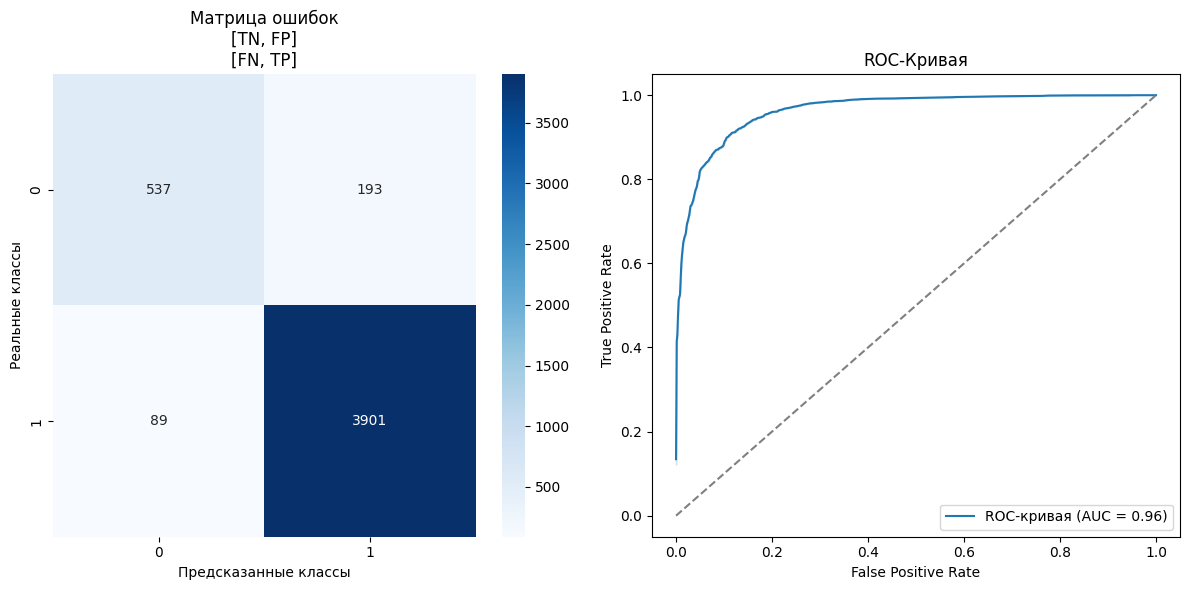

In [80]:
evaluate_model(xgbc_model, X_test_processed, y_test)

**Используемые методы и подходы:**

**Предобработка данных:**

Для анализа и обработки данных использовались библиотеки pandas, numpy, matplotlib, и json, ydata_profiling ( для отчета)

Данные по тексту песен пришлось дополнять путем парсинга (процесс описан в соответвующей ветке)

**Моделирование:**
Для машинного обучения применялись использовались машинные алгоритмы обучения CatBoostClassifier, LGBMClassifier, LinearSVC, XGBClassifier, что указывает на комплексный подход к задаче классификации. Метрики оценки f1_score, roc_auc_score, а также методы для подбора гиперпараметров и кросс-валидации.

Для глубокого обучения и работы с текстами были использованы библиотеки torch и transformers, что указывает на применение нейронных сетей и возможно, трансформеров для анализа текстов песен.


**Оптимизация моделей и оценка результатов:**

Для поиска оптимальных гиперпараметров использовались RandomizedSearchCV и StratifiedKFold.
Построение пайплайнов: Pipeline и ColumnTransformer использовались для упрощения процесса преобработки данных и интеграции различных шагов предобработки и моделирования.


Оценка результатов:

Использовались различные метрики для оценки качества моделей, включая f1_score, roc_auc_score, матрицей ошибок.

Идеально быстро и с хорошим результатом победила модель **XGBClassifier.** хорошо оценив треки на тесте

Для поиска каверов к оригиналу было использовано косинусное сходство для оценки схожести между векторами. (95%)
На инструментальных треках и треках без текста, это было сделать невозможно ( нужна аудио дорожка)


**Предложения**

## Нейросетевые подходы для обнаружения кавер-версий музыкальных треков

Для решения задачи обнаружения кавер-версий музыкальных треков с помощью нейросетевых подходов можно рассмотреть следующие варианты:

1. **Сверточные нейронные сети (CNN) для анализа аудиоспектрограмм:**
   - Сверточные нейронные сети могут анализировать спектрограммы аудиозаписей (визуальные представления частотного спектра звуков) для выявления характерных паттернов, которые могут указывать на кавер-версии.

2. **Рекуррентные нейронные сети (RNN) и Long Short-Term Memory (LSTM):**
   - Эти типы сетей эффективно обрабатывают последовательности данных, такие как временные ряды аудиосигналов или последовательности слов в текстах песен. Они могут улавливать долгосрочные зависимости в данных и использоваться для сравнения структуры и содержания песен.

3. **Трансформеры и BERT:**
   - Применение трансформеров, таких как BERT (Bidirectional Encoder Representations from Transformers), может быть особенно полезным для анализа текстов песен. Трансформеры могут учитывать контекст слов в тексте и выявлять глубокие семантические связи, что может помочь в определении схожести между оригинальными треками и их каверами.

4. **Siamese Networks или Triplet Networks:**
   - Эти типы архитектур обучаются на парах или тройках объектов, чтобы изучить, какие объекты похожи, а какие нет. Они могут использоваться для обучения на парах оригинальных треков и каверов, что позволит сети выучивать представления, специфичные для определения сходства между треками.

5. **Автоэнкодеры:**
   - Автоэнкодеры можно использовать для снижения размерности аудио-характеристик или текстовых данных. Полученные компактные векторные представления могут затем сравниваться с помощью косинусного сходства или других метрик.

6. **Смешанные модели (Hybrid Models):**
   - Можно использовать комбинацию аудио- и текстовых данных для обучения смешанных моделей. Например, сверточная сеть может обрабатывать аудиоспектрограммы, а трансформер — тексты песен. Результаты их работы могут быть объединены для принятия окончательного решения.

Эти подходы могут быть использованы отдельно или в комбинации для создания более мощной и точной системы по обнаружению кавер-версий музыкальных треков. Выбор конкретной модели или комбинации моделей зависит от доступных данных, вычислительных ресурсов и специфики задачи.
